In [1]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


Get MNIST

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]][0:1000]
x_test_38 = x_test[idx_test[3]+idx_test[8]][0:200]


# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
y_test_38 = y_test[idx_test[3]+idx_test[8]][0:200]


In [3]:
# K-Means clustering to find centers
start = time.time()
kmeans_model = KMeans(2)
kmeans_model.fit(x_train[idx_train[8]+idx_train[3]])
_38=np.reshape(kmeans_model.cluster_centers_,(-1,784))
print("Cluster Production time(sec) :", time.time() - start)


Cluster Production time(sec) : 4.667543411254883


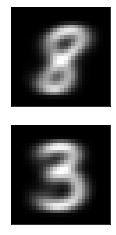

In [4]:
fig = plt.figure()

for i in range(2):
  subplot = fig.add_subplot(2,1, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i], (28, 28)), cmap='gray')

In [6]:
# # plot cluster centers as images
# imgs = centers * 255
# fig = plt.figure(figsize =(5,100))
# for i in range(50):
#   subplot = fig.add_subplot(50,2, 2*i+1)
#   subplot.imshow(np.reshape(centers[i], (7, 7)), cmap='gray')
#   subplot = fig.add_subplot(50,2, 2*i+2)
#   subplot.imshow(np.reshape(centers[i+50], (7, 7)), cmap='gray')
  
# plt.savefig('rbf_centers.png')


In [12]:

class Model:
    
    def __init__(self):
        self.m_centers = []
        self.unit = None
        self.row = None
        self.col = None
        self.x = None
        
        self.m_train_image = []
        self.m_test_image = []
        self.m_train_label = []
        self.m_test_label = []
        
        self.temp1 = None
        self.temp2 = None
        self.model = None
        
    def _Segmentation(self,unit,centers):
        self.unit = unit
        self.row = random.randrange(0,29-self.unit)
        self.col = random.randrange(0,29-self.unit)
        
        for center in centers:
            self.m_centers.extend(center[r*28+self.col : r*28+(self.col+self.unit) ] for r in range(self.row,self.row+self.unit))
        self.m_centers = np.reshape(self.m_centers,(-1,self.unit*self.unit))   
        
        self.x = np.zeros((len(centers),len(centers)))
        for i in range(len(centers)):
            self.x[i][i] = 1
        
    def _fit(self,train_image,test_image,train_label,test_label):
        
        for arr in train_image:
            self.m_train_image.extend(arr[r*28+self.col : r*28+(self.col+self.unit) ] 
                                      for r in range(self.row,self.row+self.unit))
        self.m_train_image = np.reshape(self.m_train_image,(-1,self.unit*self.unit))
        
        for arr in test_image:
            self.m_test_image.extend(arr[r*28+self.col : r*28+(self.col+self.unit) ] 
                                      for r in range(self.row,self.row+self.unit))          
        self.m_test_image = np.reshape(self.m_test_image,(-1,self.unit*self.unit))
        
        for arr in train_label:    
            self.m_train_label.extend(arr)
        self.m_train_label = np.reshape(self.m_train_label,(-1,10))
    
        
        for arr in test_label:    
            self.m_test_label.extend(arr)
        self.m_test_label = np.reshape(self.m_test_label,(-1,10))
            
    
    def _RBF(self):
        # RBF Layer
        kernel = PairwiseKernel(metric='polynomial') 
        rbf_model = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(self.m_centers,self.x)

        self.temp1 = rbf_model.predict(self.m_train_image)
        self.temp2 = rbf_model.predict(self.m_test_image)


    def _Perceptron(self):
        # Perceptron Layers
        batch_size = 128
        epochs = 100

        self.model = Sequential()
        self.model.add(Dense(10, activation='softmax', input_shape=(len(self.m_centers),)))

        self.model.summary()
        nadam=keras.optimizers.Nadam(lr=0.0005)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=nadam,
                      metrics=['accuracy'])


        # Train model
        history = self.model.fit(self.temp1, self.m_train_label,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
    def _Predict(self):
        predictions = self.model.predict(self.temp2)

        return predictions

    
    
def get_accuracy(softmax_sum,test_label):
    true=0
    for i in range(len(softmax_sum)):
        if np.argmax(softmax_sum[i])==np.argmax(test_label[i]):
            true +=1
    print("Accuracy : ", true/len(softmax_sum))

In [8]:
models = [Model() for i in range(50)]
softmax_sum = np.ones((len(x_test_38),10))
for m in models:
    m._Segmentation(7,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6023 - acc: 0.0680
Epoch 2/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5899 - acc: 0.0710
Epoch 3/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5765 - acc: 0.0730
Epoch 4/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5626 - acc: 0.0780
Epoch 5/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5485 - acc: 0.0800
Epoch 6/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5343 - acc: 0.0840
Epoch 7/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.5

1000/1000 [==============================] - 0s 17us/step - loss: 1.6807 - acc: 0.5340
Epoch 79/100
1000/1000 [==============================] - 0s 13us/step - loss: 1.6716 - acc: 0.5370
Epoch 80/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6624 - acc: 0.5390
Epoch 81/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6534 - acc: 0.5430
Epoch 82/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6446 - acc: 0.5480
Epoch 83/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6357 - acc: 0.5510
Epoch 84/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6269 - acc: 0.5540
Epoch 85/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6182 - acc: 0.5600
Epoch 86/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6096 - acc: 0.5630
Epoch 87/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6011 - acc: 0.5640
Epoch 88/100


1000/1000 [==============================] - 0s 15us/step - loss: 1.8272 - acc: 0.3600
Epoch 55/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8168 - acc: 0.3740
Epoch 56/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.8065 - acc: 0.3820
Epoch 57/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7964 - acc: 0.3900
Epoch 58/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7862 - acc: 0.3980
Epoch 59/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7762 - acc: 0.4130
Epoch 60/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7663 - acc: 0.4220
Epoch 61/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7564 - acc: 0.4280
Epoch 62/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7467 - acc: 0.4370
Epoch 63/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7370 - acc: 0.4460
Epoch 64/100


1000/1000 [==============================] - 0s 15us/step - loss: 2.0370 - acc: 0.1820
Epoch 32/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0277 - acc: 0.1830
Epoch 33/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0183 - acc: 0.1840
Epoch 34/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0091 - acc: 0.1880
Epoch 35/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9999 - acc: 0.1900
Epoch 36/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9908 - acc: 0.1890
Epoch 37/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.9816 - acc: 0.1920
Epoch 38/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9727 - acc: 0.1940
Epoch 39/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9636 - acc: 0.1960
Epoch 40/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9546 - acc: 0.1960
Epoch 41/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.4899 - acc: 0.0210
Epoch 9/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4767 - acc: 0.0340
Epoch 10/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4636 - acc: 0.0450
Epoch 11/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.4506 - acc: 0.0550
Epoch 12/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4379 - acc: 0.0630
Epoch 13/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.4252 - acc: 0.0720
Epoch 14/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4126 - acc: 0.0790
Epoch 15/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4001 - acc: 0.0890
Epoch 16/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3878 - acc: 0.0930
Epoch 17/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.3756 - acc: 0.0970
Epoch 18/100
1

1000/1000 [==============================] - 0s 17us/step - loss: 1.6463 - acc: 0.6250
Epoch 91/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.6383 - acc: 0.6250
Epoch 92/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6303 - acc: 0.6240
Epoch 93/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6223 - acc: 0.6240
Epoch 94/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6144 - acc: 0.6240
Epoch 95/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6066 - acc: 0.6250
Epoch 96/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5988 - acc: 0.6250
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5911 - acc: 0.6250
Epoch 98/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.5834 - acc: 0.6250
Epoch 99/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5758 - acc: 0.6250
Epoch 100/100

1000/1000 [==============================] - 0s 15us/step - loss: 1.5759 - acc: 0.6730
Epoch 68/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5683 - acc: 0.6730
Epoch 69/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5607 - acc: 0.6720
Epoch 70/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5533 - acc: 0.6720
Epoch 71/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5460 - acc: 0.6720
Epoch 72/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5387 - acc: 0.6710
Epoch 73/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5316 - acc: 0.6710
Epoch 74/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5246 - acc: 0.6710
Epoch 75/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5176 - acc: 0.6710
Epoch 76/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5108 - acc: 0.6710
Epoch 77/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.1530 - acc: 0.1240
Epoch 44/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.1373 - acc: 0.2070
Epoch 45/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1218 - acc: 0.2270
Epoch 46/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1065 - acc: 0.2410
Epoch 47/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0915 - acc: 0.2570
Epoch 48/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0765 - acc: 0.2770
Epoch 49/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0619 - acc: 0.2960
Epoch 50/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0473 - acc: 0.2990
Epoch 51/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0331 - acc: 0.3110
Epoch 52/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0192 - acc: 0.3150
Epoch 53/100


1000/1000 [==============================] - 0s 15us/step - loss: 3.2486 - acc: 0.1710
Epoch 21/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.2302 - acc: 0.1720
Epoch 22/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.2118 - acc: 0.1740
Epoch 23/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.1937 - acc: 0.1750
Epoch 24/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.1754 - acc: 0.1770
Epoch 25/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.1572 - acc: 0.1790
Epoch 26/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.1393 - acc: 0.1820
Epoch 27/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.1213 - acc: 0.1850
Epoch 28/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.1033 - acc: 0.1880
Epoch 29/100
1000/1000 [==============================] - 0s 14us/step - loss: 3.0855 - acc: 0.1910
Epoch 30/100


Epoch 1/100
1000/1000 [==============================] - 0s 201us/step - loss: 2.8696 - acc: 0.0020
Epoch 2/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.8570 - acc: 0.0020
Epoch 3/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.8434 - acc: 0.0030
Epoch 4/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.8293 - acc: 0.0060
Epoch 5/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.8150 - acc: 0.0080
Epoch 6/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.8006 - acc: 0.0130
Epoch 7/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.7862 - acc: 0.0190
Epoch 8/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.7719 - acc: 0.0280
Epoch 9/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.7576 - acc: 0.0320
Epoch 10/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7433 - acc: 0.0350
Epoch 11

1000/1000 [==============================] - 0s 17us/step - loss: 1.8221 - acc: 0.2510
Epoch 84/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.8114 - acc: 0.2510
Epoch 85/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8007 - acc: 0.2520
Epoch 86/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7901 - acc: 0.2560
Epoch 87/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7796 - acc: 0.2590
Epoch 88/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7690 - acc: 0.2580
Epoch 89/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7587 - acc: 0.2570
Epoch 90/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7483 - acc: 0.2500
Epoch 91/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7380 - acc: 0.2570
Epoch 92/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7278 - acc: 0.2600
Epoch 93/100


1000/1000 [==============================] - 0s 15us/step - loss: 2.3609 - acc: 0.2030
Epoch 61/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3450 - acc: 0.2050
Epoch 62/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.3292 - acc: 0.2070
Epoch 63/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3136 - acc: 0.2100
Epoch 64/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.2980 - acc: 0.2100
Epoch 65/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2825 - acc: 0.2160
Epoch 66/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2670 - acc: 0.2190
Epoch 67/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.2517 - acc: 0.2210
Epoch 68/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2363 - acc: 0.2220
Epoch 69/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.2209 - acc: 0.2230
Epoch 70/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.6671 - acc: 0.2060
Epoch 37/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6393 - acc: 0.2070
Epoch 38/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6116 - acc: 0.2080
Epoch 39/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.5843 - acc: 0.2110
Epoch 40/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5573 - acc: 0.2120
Epoch 41/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.5301 - acc: 0.2130
Epoch 42/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5035 - acc: 0.2150
Epoch 43/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4770 - acc: 0.2200
Epoch 44/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4510 - acc: 0.2260
Epoch 45/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4252 - acc: 0.2280
Epoch 46/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.4586 - acc: 0.4190
Epoch 14/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4450 - acc: 0.4190
Epoch 15/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4315 - acc: 0.4190
Epoch 16/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4180 - acc: 0.4190
Epoch 17/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4046 - acc: 0.4190
Epoch 18/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3913 - acc: 0.4210
Epoch 19/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.3779 - acc: 0.4210
Epoch 20/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3646 - acc: 0.4210
Epoch 21/100
1000/1000 [==============================] - 0s 14us/step - loss: 2.3515 - acc: 0.4210
Epoch 22/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3383 - acc: 0.4220
Epoch 23/100


1000/1000 [==============================] - 0s 17us/step - loss: 1.5598 - acc: 0.4550
Epoch 95/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5515 - acc: 0.4580
Epoch 96/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5434 - acc: 0.4580
Epoch 97/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5353 - acc: 0.4590
Epoch 98/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5273 - acc: 0.4610
Epoch 99/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5194 - acc: 0.4630
Epoch 100/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5116 - acc: 0.4640
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
____________________________________________________

1000/1000 [==============================] - 0s 16us/step - loss: 1.7873 - acc: 0.4310
Epoch 72/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7785 - acc: 0.4330
Epoch 73/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7697 - acc: 0.4360
Epoch 74/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7610 - acc: 0.4360
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7523 - acc: 0.4400
Epoch 76/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7438 - acc: 0.4420
Epoch 77/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7353 - acc: 0.4490
Epoch 78/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.7268 - acc: 0.4480
Epoch 79/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7184 - acc: 0.4470
Epoch 80/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7101 - acc: 0.4510
Epoch 81/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.0401 - acc: 0.4340
Epoch 48/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0276 - acc: 0.4370
Epoch 49/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0154 - acc: 0.4380
Epoch 50/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0035 - acc: 0.4400
Epoch 51/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9916 - acc: 0.4410
Epoch 52/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9798 - acc: 0.4430
Epoch 53/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9683 - acc: 0.4430
Epoch 54/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9567 - acc: 0.4450
Epoch 55/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9455 - acc: 0.4480
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9344 - acc: 0.4490
Epoch 57/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.2305 - acc: 0.3510
Epoch 25/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.2176 - acc: 0.3680
Epoch 26/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2046 - acc: 0.3840
Epoch 27/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.1918 - acc: 0.3940
Epoch 28/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1790 - acc: 0.4010
Epoch 29/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1664 - acc: 0.4020
Epoch 30/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.1538 - acc: 0.4050
Epoch 31/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1413 - acc: 0.4080
Epoch 32/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.1290 - acc: 0.4090
Epoch 33/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1166 - acc: 0.4130
Epoch 34/100


1000/1000 [==============================] - 0s 286us/step - loss: 3.1761 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 17us/step - loss: 3.1603 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.1434 - acc: 0.0020
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.1258 - acc: 0.0030
Epoch 5/100
1000/1000 [==============================] - 0s 17us/step - loss: 3.1080 - acc: 0.0040
Epoch 6/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.0902 - acc: 0.0050
Epoch 7/100
1000/1000 [==============================] - 0s 17us/step - loss: 3.0723 - acc: 0.0080
Epoch 8/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.0545 - acc: 0.0150
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.0368 - acc: 0.0200
Epoch 10/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.0190 - acc: 0.0220
Epoch 11/100

1000/1000 [==============================] - 0s 19us/step - loss: 1.9271 - acc: 0.5330
Epoch 84/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9152 - acc: 0.5380
Epoch 85/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9034 - acc: 0.5420
Epoch 86/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8917 - acc: 0.5440
Epoch 87/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.8801 - acc: 0.5520
Epoch 88/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8685 - acc: 0.5630
Epoch 89/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.8571 - acc: 0.5680
Epoch 90/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8457 - acc: 0.5710
Epoch 91/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8344 - acc: 0.5750
Epoch 92/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8232 - acc: 0.5790
Epoch 93/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.5414 - acc: 0.6480
Epoch 61/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5330 - acc: 0.6520
Epoch 62/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5246 - acc: 0.6540
Epoch 63/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5163 - acc: 0.6580
Epoch 64/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5081 - acc: 0.6630
Epoch 65/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5000 - acc: 0.6670
Epoch 66/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4919 - acc: 0.6690
Epoch 67/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4840 - acc: 0.6750
Epoch 68/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.4761 - acc: 0.6790
Epoch 69/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4682 - acc: 0.6840
Epoch 70/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.1484 - acc: 0.4930
Epoch 38/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.1334 - acc: 0.4950
Epoch 39/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1189 - acc: 0.4950
Epoch 40/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1045 - acc: 0.4980
Epoch 41/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0903 - acc: 0.5000
Epoch 42/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0761 - acc: 0.5010
Epoch 43/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0623 - acc: 0.5040
Epoch 44/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0487 - acc: 0.5060
Epoch 45/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0351 - acc: 0.5080
Epoch 46/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0218 - acc: 0.5100
Epoch 47/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.5517 - acc: 0.0340
Epoch 15/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5305 - acc: 0.0390
Epoch 16/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5096 - acc: 0.0410
Epoch 17/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4888 - acc: 0.0470
Epoch 18/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4685 - acc: 0.0520
Epoch 19/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4481 - acc: 0.0560
Epoch 20/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4282 - acc: 0.0600
Epoch 21/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4085 - acc: 0.0680
Epoch 22/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.3888 - acc: 0.0720
Epoch 23/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3696 - acc: 0.0800
Epoch 24/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.4852 - acc: 0.5650
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4797 - acc: 0.5650
Epoch 98/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4742 - acc: 0.5650
Epoch 99/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.4689 - acc: 0.5640
Epoch 100/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4635 - acc: 0.5650
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 0s 352us/step - loss: 2.6974 - acc: 0.1160
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6742 -

1000/1000 [==============================] - 0s 17us/step - loss: 1.3150 - acc: 0.7650
Epoch 74/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.3059 - acc: 0.7690
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.2970 - acc: 0.7690
Epoch 76/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.2883 - acc: 0.7700
Epoch 77/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.2798 - acc: 0.7710
Epoch 78/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.2716 - acc: 0.7710
Epoch 79/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.2635 - acc: 0.7720
Epoch 80/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.2556 - acc: 0.7720
Epoch 81/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.2479 - acc: 0.7720
Epoch 82/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.2404 - acc: 0.7740
Epoch 83/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.7973 - acc: 0.4060
Epoch 51/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7873 - acc: 0.4060
Epoch 52/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7774 - acc: 0.4070
Epoch 53/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7675 - acc: 0.4110
Epoch 54/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7578 - acc: 0.4160
Epoch 55/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7482 - acc: 0.4200
Epoch 56/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7386 - acc: 0.4250
Epoch 57/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7291 - acc: 0.4320
Epoch 58/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7197 - acc: 0.4390
Epoch 59/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7104 - acc: 0.4460
Epoch 60/100


1000/1000 [==============================] - 0s 18us/step - loss: 3.1837 - acc: 0.1570
Epoch 28/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.1564 - acc: 0.1580
Epoch 29/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.1291 - acc: 0.1580
Epoch 30/100
1000/1000 [==============================] - 0s 17us/step - loss: 3.1021 - acc: 0.1590
Epoch 31/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.0748 - acc: 0.1590
Epoch 32/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.0479 - acc: 0.1610
Epoch 33/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.0210 - acc: 0.1600
Epoch 34/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.9940 - acc: 0.1610
Epoch 35/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.9676 - acc: 0.1620
Epoch 36/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.9406 - acc: 0.1630
Epoch 37/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.9068 - acc: 0.0100
Epoch 5/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.8844 - acc: 0.0280
Epoch 6/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.8621 - acc: 0.0960
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.8398 - acc: 0.1080
Epoch 8/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.8175 - acc: 0.1140
Epoch 9/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.7951 - acc: 0.1200
Epoch 10/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.7728 - acc: 0.1260
Epoch 11/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7507 - acc: 0.1280
Epoch 12/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7289 - acc: 0.1350
Epoch 13/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.7069 - acc: 0.1430
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 15us/step - loss: 1.6012 - acc: 0.6910
Epoch 87/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5934 - acc: 0.6920
Epoch 88/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5858 - acc: 0.6930
Epoch 89/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5783 - acc: 0.6950
Epoch 90/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5710 - acc: 0.6940
Epoch 91/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5638 - acc: 0.6960
Epoch 92/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5566 - acc: 0.6980
Epoch 93/100
1000/1000 [==============================] - 0s 14us/step - loss: 1.5496 - acc: 0.7000
Epoch 94/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5428 - acc: 0.6990
Epoch 95/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5360 - acc: 0.7000
Epoch 96/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.7068 - acc: 0.5050
Epoch 64/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6977 - acc: 0.5130
Epoch 65/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6886 - acc: 0.5140
Epoch 66/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6797 - acc: 0.5170
Epoch 67/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6707 - acc: 0.5200
Epoch 68/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6619 - acc: 0.5250
Epoch 69/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6531 - acc: 0.5280
Epoch 70/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6443 - acc: 0.5310
Epoch 71/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6356 - acc: 0.5370
Epoch 72/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6270 - acc: 0.5430
Epoch 73/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.9502 - acc: 0.3350
Epoch 41/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9345 - acc: 0.3660
Epoch 42/100
1000/1000 [==============================] - ETA: 0s - loss: 1.9581 - acc: 0.398 - 0s 19us/step - loss: 1.9188 - acc: 0.3880
Epoch 43/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9033 - acc: 0.4100
Epoch 44/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8879 - acc: 0.4360
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8727 - acc: 0.4630
Epoch 46/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8574 - acc: 0.4980
Epoch 47/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8425 - acc: 0.5230
Epoch 48/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.8276 - acc: 0.5550
Epoch 49/100
1000/1000 [==============================] - 0s 18us/step - lo

1000/1000 [==============================] - 0s 17us/step - loss: 2.5165 - acc: 0.0760
Epoch 18/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5017 - acc: 0.0790
Epoch 19/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4870 - acc: 0.0830
Epoch 20/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4723 - acc: 0.0850
Epoch 21/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4577 - acc: 0.0870
Epoch 22/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4431 - acc: 0.0880
Epoch 23/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4286 - acc: 0.0930
Epoch 24/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.4142 - acc: 0.0980
Epoch 25/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3998 - acc: 0.1010
Epoch 26/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3854 - acc: 0.1030
Epoch 27/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.5158 - acc: 0.7240
Epoch 100/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.5067 - acc: 0.7280
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 0s 456us/step - loss: 2.0116 - acc: 0.3480
Epoch 2/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0001 - acc: 0.3550
Epoch 3/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9878 - acc: 0.3610
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9751 - acc: 0.3700
Epoch 5/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9621 - ac

1000/1000 [==============================] - 0s 17us/step - loss: 1.2897 - acc: 0.7370
Epoch 77/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2834 - acc: 0.7370
Epoch 78/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.2771 - acc: 0.7370
Epoch 79/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2709 - acc: 0.7370
Epoch 80/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.2648 - acc: 0.7370
Epoch 81/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2587 - acc: 0.7370
Epoch 82/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.2528 - acc: 0.7370
Epoch 83/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.2468 - acc: 0.7370
Epoch 84/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.2410 - acc: 0.7370
Epoch 85/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.2352 - acc: 0.7370
Epoch 86/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.8252 - acc: 0.4790
Epoch 54/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8149 - acc: 0.4780
Epoch 55/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8046 - acc: 0.4760
Epoch 56/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7943 - acc: 0.4750
Epoch 57/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7842 - acc: 0.4740
Epoch 58/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7742 - acc: 0.4740
Epoch 59/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7641 - acc: 0.4740
Epoch 60/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7543 - acc: 0.4730
Epoch 61/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7444 - acc: 0.4730
Epoch 62/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7347 - acc: 0.4730
Epoch 63/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.6504 - acc: 0.2410
Epoch 31/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6307 - acc: 0.2440
Epoch 32/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6109 - acc: 0.2470
Epoch 33/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5912 - acc: 0.2490
Epoch 34/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5718 - acc: 0.2530
Epoch 35/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5521 - acc: 0.2540
Epoch 36/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5328 - acc: 0.2590
Epoch 37/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5137 - acc: 0.2630
Epoch 38/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4943 - acc: 0.2680
Epoch 39/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4753 - acc: 0.2720
Epoch 40/100


1000/1000 [==============================] - 0s 16us/step - loss: 2.8963 - acc: 0.1870
Epoch 8/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.8806 - acc: 0.1880
Epoch 9/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.8651 - acc: 0.1900
Epoch 10/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.8495 - acc: 0.1900
Epoch 11/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.8340 - acc: 0.1910
Epoch 12/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.8186 - acc: 0.1920
Epoch 13/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.8032 - acc: 0.1920
Epoch 14/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.7879 - acc: 0.1940
Epoch 15/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.7727 - acc: 0.1940
Epoch 16/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.7574 - acc: 0.1960
Epoch 17/100
10

1000/1000 [==============================] - 0s 15us/step - loss: 1.8109 - acc: 0.2880
Epoch 90/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8003 - acc: 0.2880
Epoch 91/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7899 - acc: 0.2880
Epoch 92/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7795 - acc: 0.2880
Epoch 93/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7691 - acc: 0.2890
Epoch 94/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7589 - acc: 0.2890
Epoch 95/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7487 - acc: 0.2890
Epoch 96/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.7386 - acc: 0.2890
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7285 - acc: 0.2890
Epoch 98/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7186 - acc: 0.2890
Epoch 99/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.6838 - acc: 0.6190
Epoch 67/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6759 - acc: 0.6190
Epoch 68/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6679 - acc: 0.6190
Epoch 69/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6601 - acc: 0.6180
Epoch 70/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6523 - acc: 0.6180
Epoch 71/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.6446 - acc: 0.6180
Epoch 72/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6370 - acc: 0.6180
Epoch 73/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6294 - acc: 0.6180
Epoch 74/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6218 - acc: 0.6180
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6144 - acc: 0.6180
Epoch 76/100


1000/1000 [==============================] - 0s 21us/step - loss: 3.2781 - acc: 0.1530
Epoch 44/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.2571 - acc: 0.1540
Epoch 45/100
1000/1000 [==============================] - 0s 17us/step - loss: 3.2361 - acc: 0.1540
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.2150 - acc: 0.1560
Epoch 47/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.1942 - acc: 0.2010
Epoch 48/100
1000/1000 [==============================] - 0s 15us/step - loss: 3.1732 - acc: 0.2420
Epoch 49/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.1526 - acc: 0.2440
Epoch 50/100
1000/1000 [==============================] - 0s 16us/step - loss: 3.1318 - acc: 0.2470
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.1109 - acc: 0.2500
Epoch 52/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.0904 - acc: 0.2510
Epoch 53/100


1000/1000 [==============================] - 0s 16us/step - loss: 2.0157 - acc: 0.5140
Epoch 21/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0044 - acc: 0.5170
Epoch 22/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9932 - acc: 0.5170
Epoch 23/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9821 - acc: 0.5170
Epoch 24/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9711 - acc: 0.5170
Epoch 25/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9602 - acc: 0.5170
Epoch 26/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9494 - acc: 0.5170
Epoch 27/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9388 - acc: 0.5170
Epoch 28/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9282 - acc: 0.5170
Epoch 29/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9178 - acc: 0.5170
Epoch 30/100


Epoch 1/100
1000/1000 [==============================] - 1s 544us/step - loss: 2.7055 - acc: 0.2500
Epoch 2/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6921 - acc: 0.2630
Epoch 3/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6777 - acc: 0.2730
Epoch 4/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.6627 - acc: 0.2800
Epoch 5/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6475 - acc: 0.2890
Epoch 6/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6323 - acc: 0.2940
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6171 - acc: 0.2990
Epoch 8/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6019 - acc: 0.3050
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5867 - acc: 0.3110
Epoch 10/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5717 - acc: 0.3170
Epoch 11

1000/1000 [==============================] - 0s 18us/step - loss: 1.6702 - acc: 0.5690
Epoch 84/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6607 - acc: 0.5720
Epoch 85/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6514 - acc: 0.5740
Epoch 86/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6421 - acc: 0.5750
Epoch 87/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6328 - acc: 0.5770
Epoch 88/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6237 - acc: 0.5770
Epoch 89/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6145 - acc: 0.5780
Epoch 90/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6056 - acc: 0.5820
Epoch 91/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5966 - acc: 0.5880
Epoch 92/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5878 - acc: 0.5920
Epoch 93/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.5830 - acc: 0.4770
Epoch 61/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5747 - acc: 0.4790
Epoch 62/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5665 - acc: 0.4810
Epoch 63/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5583 - acc: 0.4860
Epoch 64/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5502 - acc: 0.4870
Epoch 65/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5421 - acc: 0.4920
Epoch 66/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5341 - acc: 0.4920
Epoch 67/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5261 - acc: 0.4950
Epoch 68/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5183 - acc: 0.5010
Epoch 69/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5104 - acc: 0.5040
Epoch 70/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.8880 - acc: 0.4410
Epoch 38/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8761 - acc: 0.4430
Epoch 39/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8644 - acc: 0.4500
Epoch 40/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8528 - acc: 0.4560
Epoch 41/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8414 - acc: 0.4560
Epoch 42/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8299 - acc: 0.4640
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8186 - acc: 0.4690
Epoch 44/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8075 - acc: 0.4730
Epoch 45/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7964 - acc: 0.4780
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7854 - acc: 0.4820
Epoch 47/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.7005 - acc: 0.5050
Epoch 15/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.6848 - acc: 0.5080
Epoch 16/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6688 - acc: 0.5100
Epoch 17/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.6532 - acc: 0.5100
Epoch 18/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6377 - acc: 0.5100
Epoch 19/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6223 - acc: 0.5100
Epoch 20/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6070 - acc: 0.5120
Epoch 21/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5919 - acc: 0.5120
Epoch 22/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.5769 - acc: 0.5120
Epoch 23/100
1000/1000 [==============================] - ETA: 0s - loss: 2.0598 - acc: 0.617 - 0s 18us/step - lo

1000/1000 [==============================] - 0s 18us/step - loss: 1.6459 - acc: 0.5260
Epoch 96/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6360 - acc: 0.5260
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6263 - acc: 0.5260
Epoch 98/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6165 - acc: 0.5260
Epoch 99/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6070 - acc: 0.5280
Epoch 100/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5975 - acc: 0.5280
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 612us/step - loss: 2.3673 

1000/1000 [==============================] - 0s 18us/step - loss: 1.5159 - acc: 0.7510
Epoch 73/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5074 - acc: 0.7570
Epoch 74/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4990 - acc: 0.7600
Epoch 75/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4906 - acc: 0.7640
Epoch 76/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4823 - acc: 0.7700
Epoch 77/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4742 - acc: 0.7700
Epoch 78/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4661 - acc: 0.7710
Epoch 79/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4581 - acc: 0.7740
Epoch 80/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4502 - acc: 0.7750
Epoch 81/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.4424 - acc: 0.7760
Epoch 82/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.2984 - acc: 0.2440
Epoch 50/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2815 - acc: 0.2450
Epoch 51/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2647 - acc: 0.2490
Epoch 52/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2481 - acc: 0.2500
Epoch 53/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.2315 - acc: 0.2540
Epoch 54/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2149 - acc: 0.2540
Epoch 55/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1986 - acc: 0.2580
Epoch 56/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1825 - acc: 0.2630
Epoch 57/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1664 - acc: 0.2640
Epoch 58/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1504 - acc: 0.2660
Epoch 59/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.1815 - acc: 0.4120
Epoch 27/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1698 - acc: 0.4120
Epoch 28/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1582 - acc: 0.4160
Epoch 29/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1467 - acc: 0.4170
Epoch 30/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1353 - acc: 0.4200
Epoch 31/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1239 - acc: 0.4210
Epoch 32/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1127 - acc: 0.4210
Epoch 33/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1016 - acc: 0.4210
Epoch 34/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0905 - acc: 0.4220
Epoch 35/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0795 - acc: 0.4240
Epoch 36/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.5858 - acc: 0.0050
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5729 - acc: 0.0110
Epoch 5/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5599 - acc: 0.0170
Epoch 6/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5469 - acc: 0.0190
Epoch 7/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.5339 - acc: 0.0220
Epoch 8/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5210 - acc: 0.0250
Epoch 9/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5081 - acc: 0.0330
Epoch 10/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4953 - acc: 0.0340
Epoch 11/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4826 - acc: 0.0350
Epoch 12/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4700 - acc: 0.0370
Epoch 13/100
1000/1

1000/1000 [==============================] - 0s 18us/step - loss: 1.7174 - acc: 0.5170
Epoch 86/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7093 - acc: 0.5170
Epoch 87/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7013 - acc: 0.5170
Epoch 88/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6933 - acc: 0.5170
Epoch 89/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6854 - acc: 0.5170
Epoch 90/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6776 - acc: 0.5170
Epoch 91/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6698 - acc: 0.5170
Epoch 92/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6620 - acc: 0.5170
Epoch 93/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6544 - acc: 0.5170
Epoch 94/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6468 - acc: 0.5170
Epoch 95/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.0862 - acc: 0.4740
Epoch 61/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0724 - acc: 0.4750
Epoch 62/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0586 - acc: 0.4750
Epoch 63/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0453 - acc: 0.4750
Epoch 64/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0318 - acc: 0.4750
Epoch 65/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0186 - acc: 0.4750
Epoch 66/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0052 - acc: 0.4760
Epoch 67/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9923 - acc: 0.4760
Epoch 68/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9793 - acc: 0.4760
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9665 - acc: 0.4760
Epoch 70/100


1000/1000 [==============================] - 0s 16us/step - loss: 2.0994 - acc: 0.4780
Epoch 38/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0753 - acc: 0.4830
Epoch 39/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0515 - acc: 0.4890
Epoch 40/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0283 - acc: 0.4930
Epoch 41/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0056 - acc: 0.4950
Epoch 42/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9835 - acc: 0.4990
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9614 - acc: 0.5040
Epoch 44/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9402 - acc: 0.5070
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9191 - acc: 0.5110
Epoch 46/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8987 - acc: 0.5110
Epoch 47/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.5085 - acc: 0.2420
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4903 - acc: 0.2640
Epoch 16/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.4721 - acc: 0.2830
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4540 - acc: 0.3060
Epoch 18/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4361 - acc: 0.3300
Epoch 19/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4182 - acc: 0.3410
Epoch 20/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4005 - acc: 0.3710
Epoch 21/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.3830 - acc: 0.3960
Epoch 22/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3654 - acc: 0.4210
Epoch 23/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3481 - acc: 0.4360
Epoch 24/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.4719 - acc: 0.8180
Epoch 97/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4644 - acc: 0.8190
Epoch 98/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4570 - acc: 0.8220
Epoch 99/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.4497 - acc: 0.8220
Epoch 100/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4424 - acc: 0.8220
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 708us/step - loss: 1.7182 - acc: 0.4350
Epoch 2/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7089 -

1000/1000 [==============================] - 0s 17us/step - loss: 1.1718 - acc: 0.7300
Epoch 74/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1669 - acc: 0.7320
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.1619 - acc: 0.7330
Epoch 76/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1570 - acc: 0.7350
Epoch 77/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.1522 - acc: 0.7350
Epoch 78/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1474 - acc: 0.7350
Epoch 79/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.1427 - acc: 0.7360
Epoch 80/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1379 - acc: 0.7360
Epoch 81/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1333 - acc: 0.7380
Epoch 82/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.1287 - acc: 0.7390
Epoch 83/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.1513 - acc: 0.4410
Epoch 50/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1406 - acc: 0.4420
Epoch 51/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1299 - acc: 0.4420
Epoch 52/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1193 - acc: 0.4440
Epoch 53/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1087 - acc: 0.4440
Epoch 54/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0982 - acc: 0.4440
Epoch 55/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0878 - acc: 0.4440
Epoch 56/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0775 - acc: 0.4440
Epoch 57/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0671 - acc: 0.4440
Epoch 58/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0569 - acc: 0.4440
Epoch 59/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.6339 - acc: 0.1130
Epoch 26/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6152 - acc: 0.1160
Epoch 27/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5965 - acc: 0.1200
Epoch 28/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5778 - acc: 0.1240
Epoch 29/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5593 - acc: 0.1290
Epoch 30/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5407 - acc: 0.1340
Epoch 31/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5225 - acc: 0.1390
Epoch 32/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5040 - acc: 0.1390
Epoch 33/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4862 - acc: 0.1400
Epoch 34/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4679 - acc: 0.1450
Epoch 35/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.0261 - acc: 0.1380
Epoch 3/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0082 - acc: 0.1540
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9898 - acc: 0.1730
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9711 - acc: 0.1900
Epoch 6/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9526 - acc: 0.2110
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9343 - acc: 0.2410
Epoch 8/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.9163 - acc: 0.2700
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8984 - acc: 0.2980
Epoch 10/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8808 - acc: 0.3300
Epoch 11/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8634 - acc: 0.3590
Epoch 12/100
1000/10

1000/1000 [==============================] - 0s 20us/step - loss: 1.1098 - acc: 0.8340
Epoch 85/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.1045 - acc: 0.8340
Epoch 86/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.0993 - acc: 0.8340
Epoch 87/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.0942 - acc: 0.8340
Epoch 88/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.0891 - acc: 0.8340
Epoch 89/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.0841 - acc: 0.8330
Epoch 90/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.0792 - acc: 0.8330
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.0744 - acc: 0.8330
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.0697 - acc: 0.8330
Epoch 93/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.0650 - acc: 0.8320
Epoch 94/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.9377 - acc: 0.4640
Epoch 62/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9254 - acc: 0.4670
Epoch 63/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9133 - acc: 0.4710
Epoch 64/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9011 - acc: 0.4760
Epoch 65/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8891 - acc: 0.4820
Epoch 66/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8771 - acc: 0.4890
Epoch 67/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8653 - acc: 0.4910
Epoch 68/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8535 - acc: 0.4980
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8419 - acc: 0.5010
Epoch 70/100
1000/1000 [==============================] - 0s 15us/step - loss: 1.8303 - acc: 0.5020
Epoch 71/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.4287 - acc: 0.0000e+00
Epoch 38/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4085 - acc: 0.0000e+00
Epoch 39/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3882 - acc: 0.0000e+00
Epoch 40/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3679 - acc: 0.0000e+00
Epoch 41/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3482 - acc: 0.0000e+00
Epoch 42/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3277 - acc: 0.0090
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3082 - acc: 0.0140
Epoch 44/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.2885 - acc: 0.0180
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2691 - acc: 0.0210
Epoch 46/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2495 - acc: 

1000/1000 [==============================] - 0s 19us/step - loss: 2.6922 - acc: 0.1490
Epoch 15/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.6764 - acc: 0.1560
Epoch 16/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6607 - acc: 0.1600
Epoch 17/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.6451 - acc: 0.1740
Epoch 18/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6296 - acc: 0.1820
Epoch 19/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6141 - acc: 0.1920
Epoch 20/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.5988 - acc: 0.1970
Epoch 21/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5834 - acc: 0.2020
Epoch 22/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.5682 - acc: 0.2140
Epoch 23/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5531 - acc: 0.2220
Epoch 24/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.6617 - acc: 0.5070
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6522 - acc: 0.5080
Epoch 98/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6428 - acc: 0.5100
Epoch 99/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6334 - acc: 0.5100
Epoch 100/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6241 - acc: 0.5110


In [13]:
get_accuracy(softmax_sum,y_test_38)

Accuracy :  0.855


In [14]:
models = [Model() for i in range(50)]
softmax_sum = np.ones((len(x_test_38),10))
for m in models:
    m._Segmentation(14,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 839us/step - loss: 2.9209 - acc: 0.0640
Epoch 2/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.9083 - acc: 0.0650
Epoch 3/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.8947 - acc: 0.0660
Epoch 4/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.8806 - acc: 0.0700
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.8663 - acc: 0.0710
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.8519 - acc: 0.0720
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - loss: 2

1000/1000 [==============================] - 0s 16us/step - loss: 1.9433 - acc: 0.3280
Epoch 79/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9324 - acc: 0.3350
Epoch 80/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9216 - acc: 0.3410
Epoch 81/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9108 - acc: 0.3550
Epoch 82/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9001 - acc: 0.3600
Epoch 83/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8894 - acc: 0.3650
Epoch 84/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8788 - acc: 0.3720
Epoch 85/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8682 - acc: 0.3790
Epoch 86/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8577 - acc: 0.3920
Epoch 87/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8473 - acc: 0.4020
Epoch 88/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.0883 - acc: 0.3140
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0753 - acc: 0.3220
Epoch 57/100
1000/1000 [==============================] - 0s 15us/step - loss: 2.0623 - acc: 0.3360
Epoch 58/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0493 - acc: 0.3420
Epoch 59/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0365 - acc: 0.3500
Epoch 60/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0238 - acc: 0.3600
Epoch 61/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0110 - acc: 0.3690
Epoch 62/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.9984 - acc: 0.3790
Epoch 63/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9858 - acc: 0.3910
Epoch 64/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9733 - acc: 0.4080
Epoch 65/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.9185 - acc: 0.4490
Epoch 33/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.9075 - acc: 0.4530
Epoch 34/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8966 - acc: 0.4560
Epoch 35/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8857 - acc: 0.4620
Epoch 36/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8749 - acc: 0.4650
Epoch 37/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8642 - acc: 0.4670
Epoch 38/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8535 - acc: 0.4720
Epoch 39/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8429 - acc: 0.4750
Epoch 40/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8324 - acc: 0.4770
Epoch 41/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8220 - acc: 0.4810
Epoch 42/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.2418 - acc: 0.0150
Epoch 10/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2281 - acc: 0.0210
Epoch 11/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2146 - acc: 0.0310
Epoch 12/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2011 - acc: 0.0510
Epoch 13/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1876 - acc: 0.0690
Epoch 14/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1743 - acc: 0.0940
Epoch 15/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1610 - acc: 0.1210
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1478 - acc: 0.1370
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1347 - acc: 0.1650
Epoch 18/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1216 - acc: 0.1900
Epoch 19/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.3666 - acc: 0.7670
Epoch 92/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.3589 - acc: 0.7730
Epoch 93/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3512 - acc: 0.7780
Epoch 94/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.3437 - acc: 0.7780
Epoch 95/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3362 - acc: 0.7800
Epoch 96/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3287 - acc: 0.7820
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3214 - acc: 0.7860
Epoch 98/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3140 - acc: 0.7900
Epoch 99/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.3068 - acc: 0.7920
Epoch 100/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2996 - acc: 0.7940
____________

1000/1000 [==============================] - 0s 16us/step - loss: 1.6522 - acc: 0.7320
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6427 - acc: 0.7380
Epoch 70/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6333 - acc: 0.7470
Epoch 71/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6239 - acc: 0.7510
Epoch 72/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6146 - acc: 0.7570
Epoch 73/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6054 - acc: 0.7660
Epoch 74/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5962 - acc: 0.7710
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5872 - acc: 0.7700
Epoch 76/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5782 - acc: 0.7710
Epoch 77/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5692 - acc: 0.7770
Epoch 78/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.1078 - acc: 0.4400
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0950 - acc: 0.4410
Epoch 47/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0822 - acc: 0.4410
Epoch 48/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.0695 - acc: 0.4420
Epoch 49/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0568 - acc: 0.4420
Epoch 50/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0442 - acc: 0.4420
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0318 - acc: 0.4420
Epoch 52/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0192 - acc: 0.4440
Epoch 53/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0069 - acc: 0.4460
Epoch 54/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9945 - acc: 0.4460
Epoch 55/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.2120 - acc: 0.1810
Epoch 23/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1990 - acc: 0.1900
Epoch 24/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1860 - acc: 0.1940
Epoch 25/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1731 - acc: 0.2050
Epoch 26/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1602 - acc: 0.2130
Epoch 27/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1474 - acc: 0.2220
Epoch 28/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1347 - acc: 0.2380
Epoch 29/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.1220 - acc: 0.2550
Epoch 30/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1095 - acc: 0.2670
Epoch 31/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.0970 - acc: 0.2850
Epoch 32/100


Epoch 1/100
1000/1000 [==============================] - 1s 934us/step - loss: 2.2955 - acc: 0.0600
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2831 - acc: 0.0710
Epoch 3/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2698 - acc: 0.0870
Epoch 4/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2560 - acc: 0.0920
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2421 - acc: 0.1010
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2280 - acc: 0.1130
Epoch 7/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2141 - acc: 0.1260
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2002 - acc: 0.1370
Epoch 9/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1864 - acc: 0.1500
Epoch 10/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1727 - acc: 0.1600
Epoch 11

1000/1000 [==============================] - 0s 19us/step - loss: 1.3730 - acc: 0.7990
Epoch 84/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3648 - acc: 0.8000
Epoch 85/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3567 - acc: 0.8010
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3487 - acc: 0.8010
Epoch 87/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3407 - acc: 0.8010
Epoch 88/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3328 - acc: 0.8010
Epoch 89/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3249 - acc: 0.8010
Epoch 90/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.3172 - acc: 0.8010
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3095 - acc: 0.8010
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3019 - acc: 0.8020
Epoch 93/100


1000/1000 [==============================] - 0s 17us/step - loss: 1.9289 - acc: 0.2340
Epoch 61/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9174 - acc: 0.2440
Epoch 62/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9059 - acc: 0.2540
Epoch 63/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8944 - acc: 0.2660
Epoch 64/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8831 - acc: 0.2700
Epoch 65/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8717 - acc: 0.2780
Epoch 66/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8604 - acc: 0.2840
Epoch 67/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8492 - acc: 0.2880
Epoch 68/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.8381 - acc: 0.2950
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8270 - acc: 0.3070
Epoch 70/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3195 - acc: 0.1020
Epoch 38/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.3063 - acc: 0.1090
Epoch 39/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2932 - acc: 0.1200
Epoch 40/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2801 - acc: 0.1250
Epoch 41/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2672 - acc: 0.1310
Epoch 42/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2542 - acc: 0.1340
Epoch 43/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2414 - acc: 0.1380
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2286 - acc: 0.1420
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2158 - acc: 0.1470
Epoch 46/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.2031 - acc: 0.1530
Epoch 47/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.4011 - acc: 0.3670
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3880 - acc: 0.3960
Epoch 16/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3751 - acc: 0.4100
Epoch 17/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3621 - acc: 0.4290
Epoch 18/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.3493 - acc: 0.4380
Epoch 19/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3365 - acc: 0.4450
Epoch 20/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3239 - acc: 0.4470
Epoch 21/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3112 - acc: 0.4510
Epoch 22/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2986 - acc: 0.4520
Epoch 23/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2862 - acc: 0.4550
Epoch 24/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.5396 - acc: 0.4810
Epoch 96/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5312 - acc: 0.4810
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5229 - acc: 0.4820
Epoch 98/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5147 - acc: 0.4860
Epoch 99/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5066 - acc: 0.4880
Epoch 100/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4984 - acc: 0.4910
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 950us/step - loss: 2.7099 

1000/1000 [==============================] - 0s 19us/step - loss: 1.8086 - acc: 0.4870
Epoch 73/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7983 - acc: 0.4880
Epoch 74/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7880 - acc: 0.4900
Epoch 75/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7778 - acc: 0.4970
Epoch 76/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.7677 - acc: 0.5000
Epoch 77/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7576 - acc: 0.5030
Epoch 78/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7477 - acc: 0.5060
Epoch 79/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7378 - acc: 0.5070
Epoch 80/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7279 - acc: 0.5100
Epoch 81/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7181 - acc: 0.5160
Epoch 82/100


1000/1000 [==============================] - 0s 17us/step - loss: 1.5789 - acc: 0.7440
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5688 - acc: 0.7490
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5589 - acc: 0.7560
Epoch 52/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5490 - acc: 0.7650
Epoch 53/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5392 - acc: 0.7700
Epoch 54/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5295 - acc: 0.7730
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5199 - acc: 0.7800
Epoch 56/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5104 - acc: 0.7830
Epoch 57/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5009 - acc: 0.7860
Epoch 58/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4916 - acc: 0.7900
Epoch 59/100


1000/1000 [==============================] - 0s 17us/step - loss: 2.8266 - acc: 0.1140
Epoch 27/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.8111 - acc: 0.1150
Epoch 28/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7955 - acc: 0.1170
Epoch 29/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.7802 - acc: 0.1160
Epoch 30/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7647 - acc: 0.1180
Epoch 31/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.7494 - acc: 0.1180
Epoch 32/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.7340 - acc: 0.1180
Epoch 33/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.7188 - acc: 0.1180
Epoch 34/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.7035 - acc: 0.1180
Epoch 35/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6883 - acc: 0.1200
Epoch 36/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.3096 - acc: 0.0000e+00
Epoch 4/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2959 - acc: 0.0010
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2820 - acc: 0.0030
Epoch 6/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2680 - acc: 0.0080
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2541 - acc: 0.0170
Epoch 8/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2403 - acc: 0.0270
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2265 - acc: 0.0320
Epoch 10/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2129 - acc: 0.0390
Epoch 11/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.1993 - acc: 0.0510
Epoch 12/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1857 - acc: 0.0550
Epoch 13/100
10

1000/1000 [==============================] - 0s 19us/step - loss: 1.4357 - acc: 0.7180
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4285 - acc: 0.7190
Epoch 87/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4214 - acc: 0.7190
Epoch 88/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4144 - acc: 0.7190
Epoch 89/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4074 - acc: 0.7190
Epoch 90/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4005 - acc: 0.7210
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3937 - acc: 0.7210
Epoch 92/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3870 - acc: 0.7210
Epoch 93/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3803 - acc: 0.7220
Epoch 94/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3737 - acc: 0.7240
Epoch 95/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.4831 - acc: 0.8100
Epoch 63/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4742 - acc: 0.8100
Epoch 64/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4655 - acc: 0.8100
Epoch 65/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4567 - acc: 0.8100
Epoch 66/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4482 - acc: 0.8110
Epoch 67/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4396 - acc: 0.8120
Epoch 68/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4312 - acc: 0.8120
Epoch 69/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.4228 - acc: 0.8120
Epoch 70/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4146 - acc: 0.8120
Epoch 71/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4063 - acc: 0.8130
Epoch 72/100


1000/1000 [==============================] - 0s 16us/step - loss: 1.8531 - acc: 0.4770
Epoch 40/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8422 - acc: 0.4830
Epoch 41/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8315 - acc: 0.4890
Epoch 42/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8207 - acc: 0.4960
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8101 - acc: 0.4950
Epoch 44/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7995 - acc: 0.4990
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7891 - acc: 0.5060
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7787 - acc: 0.5110
Epoch 47/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7684 - acc: 0.5170
Epoch 48/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7581 - acc: 0.5200
Epoch 49/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.5194 - acc: 0.0270
Epoch 17/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5054 - acc: 0.0300
Epoch 18/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4915 - acc: 0.0340
Epoch 19/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4777 - acc: 0.0390
Epoch 20/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4639 - acc: 0.0500
Epoch 21/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4503 - acc: 0.0570
Epoch 22/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4366 - acc: 0.0650
Epoch 23/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.4230 - acc: 0.0730
Epoch 24/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4095 - acc: 0.0800
Epoch 25/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.3961 - acc: 0.0890
Epoch 26/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.5782 - acc: 0.5760
Epoch 99/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5693 - acc: 0.5810
Epoch 100/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5604 - acc: 0.5960
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.5700 - acc: 0.1020
Epoch 2/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5576 - acc: 0.1060
Epoch 3/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5442 - acc: 0.1140
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5303 - acc

1000/1000 [==============================] - 0s 19us/step - loss: 1.6941 - acc: 0.5160
Epoch 76/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6848 - acc: 0.5170
Epoch 77/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6756 - acc: 0.5180
Epoch 78/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6665 - acc: 0.5200
Epoch 79/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6574 - acc: 0.5200
Epoch 80/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6483 - acc: 0.5190
Epoch 81/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6394 - acc: 0.5190
Epoch 82/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6304 - acc: 0.5190
Epoch 83/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6216 - acc: 0.5190
Epoch 84/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6128 - acc: 0.5270
Epoch 85/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.5973 - acc: 0.8060
Epoch 53/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5871 - acc: 0.8060
Epoch 54/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5769 - acc: 0.8080
Epoch 55/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5669 - acc: 0.8080
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5569 - acc: 0.8090
Epoch 57/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5470 - acc: 0.8090
Epoch 58/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5372 - acc: 0.8100
Epoch 59/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5274 - acc: 0.8120
Epoch 60/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5178 - acc: 0.8140
Epoch 61/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5082 - acc: 0.8140
Epoch 62/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3423 - acc: 0.0300
Epoch 30/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.3288 - acc: 0.0310
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3153 - acc: 0.0340
Epoch 32/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3020 - acc: 0.0410
Epoch 33/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2886 - acc: 0.0430
Epoch 34/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2753 - acc: 0.0530
Epoch 35/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2621 - acc: 0.0550
Epoch 36/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2488 - acc: 0.0610
Epoch 37/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2357 - acc: 0.0660
Epoch 38/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.2226 - acc: 0.0710
Epoch 39/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.7571 - acc: 0.0740
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.7420 - acc: 0.0790
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.7269 - acc: 0.0830
Epoch 9/100
1000/1000 [==============================] - 0s 16us/step - loss: 2.7119 - acc: 0.0880
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6970 - acc: 0.0930
Epoch 11/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6821 - acc: 0.1030
Epoch 12/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.6672 - acc: 0.1090
Epoch 13/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6524 - acc: 0.1160
Epoch 14/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.6377 - acc: 0.1200
Epoch 15/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6231 - acc: 0.1250
Epoch 16/100
100

1000/1000 [==============================] - 0s 21us/step - loss: 1.7077 - acc: 0.5210
Epoch 89/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6977 - acc: 0.5220
Epoch 90/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6877 - acc: 0.5220
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6778 - acc: 0.5220
Epoch 92/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6680 - acc: 0.5220
Epoch 93/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6582 - acc: 0.5220
Epoch 94/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.6486 - acc: 0.5220
Epoch 95/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6390 - acc: 0.5220
Epoch 96/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6294 - acc: 0.5220
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6200 - acc: 0.5220
Epoch 98/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.3416 - acc: 0.8500
Epoch 66/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3332 - acc: 0.8510
Epoch 67/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3248 - acc: 0.8530
Epoch 68/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3165 - acc: 0.8530
Epoch 69/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.3084 - acc: 0.8530
Epoch 70/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3003 - acc: 0.8530
Epoch 71/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2923 - acc: 0.8520
Epoch 72/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.2844 - acc: 0.8510
Epoch 73/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2765 - acc: 0.8510
Epoch 74/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2688 - acc: 0.8520
Epoch 75/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.9258 - acc: 0.2030
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9141 - acc: 0.2100
Epoch 44/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9025 - acc: 0.2190
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8910 - acc: 0.2280
Epoch 46/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8795 - acc: 0.2330
Epoch 47/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8681 - acc: 0.2430
Epoch 48/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8567 - acc: 0.2540
Epoch 49/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8455 - acc: 0.2650
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8343 - acc: 0.2810
Epoch 51/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8231 - acc: 0.2900
Epoch 52/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.3666 - acc: 0.3730
Epoch 20/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3530 - acc: 0.3920
Epoch 21/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3395 - acc: 0.4060
Epoch 22/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3261 - acc: 0.4130
Epoch 23/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3127 - acc: 0.4180
Epoch 24/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.2995 - acc: 0.4250
Epoch 25/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2863 - acc: 0.4270
Epoch 26/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2731 - acc: 0.4320
Epoch 27/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2601 - acc: 0.4340
Epoch 28/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2471 - acc: 0.4400
Epoch 29/100


Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.4326 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4205 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4076 - acc: 0.0020
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3941 - acc: 0.0030
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3805 - acc: 0.0040
Epoch 6/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3668 - acc: 0.0080
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3532 - acc: 0.0130
Epoch 8/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3396 - acc: 0.0190
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3261 - acc: 0.0260
Epoch 10/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3126 - acc: 0.0360
Ep

Epoch 83/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5111 - acc: 0.7250
Epoch 84/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5026 - acc: 0.7290
Epoch 85/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4942 - acc: 0.7330
Epoch 86/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4859 - acc: 0.7360
Epoch 87/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4776 - acc: 0.7390
Epoch 88/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4694 - acc: 0.7420
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4612 - acc: 0.7430
Epoch 90/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4531 - acc: 0.7470
Epoch 91/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4451 - acc: 0.7480
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4372 - acc: 0.7530


1000/1000 [==============================] - 0s 22us/step - loss: 1.9038 - acc: 0.3100
Epoch 61/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8928 - acc: 0.3190
Epoch 62/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8819 - acc: 0.3350
Epoch 63/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8710 - acc: 0.3420
Epoch 64/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8603 - acc: 0.3520
Epoch 65/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8496 - acc: 0.3550
Epoch 66/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8390 - acc: 0.3690
Epoch 67/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8284 - acc: 0.3800
Epoch 68/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8179 - acc: 0.3870
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8076 - acc: 0.3930
Epoch 70/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.4321 - acc: 0.7890
Epoch 38/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4234 - acc: 0.7910
Epoch 39/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4148 - acc: 0.7910
Epoch 40/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4062 - acc: 0.7910
Epoch 41/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3977 - acc: 0.7930
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3894 - acc: 0.7930
Epoch 43/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3811 - acc: 0.7920
Epoch 44/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.3729 - acc: 0.7920
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3647 - acc: 0.7920
Epoch 46/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3567 - acc: 0.7880
Epoch 47/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.4836 - acc: 0.0100
Epoch 15/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4694 - acc: 0.0100
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4552 - acc: 0.0150
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4411 - acc: 0.0170
Epoch 18/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4270 - acc: 0.0180
Epoch 19/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4131 - acc: 0.0200
Epoch 20/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3992 - acc: 0.0290
Epoch 21/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3854 - acc: 0.0300
Epoch 22/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3716 - acc: 0.0350
Epoch 23/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3579 - acc: 0.0350
Epoch 24/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.5573 - acc: 0.7300
Epoch 97/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5490 - acc: 0.7350
Epoch 98/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5407 - acc: 0.7370
Epoch 99/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5326 - acc: 0.7430
Epoch 100/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5245 - acc: 0.7440
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3688 - acc: 0.0170
Epoch 2/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3559 - a

1000/1000 [==============================] - 0s 20us/step - loss: 1.5103 - acc: 0.7640
Epoch 74/100
1000/1000 [==============================] - 0s 16us/step - loss: 1.5015 - acc: 0.7640
Epoch 75/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4928 - acc: 0.7650
Epoch 76/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4841 - acc: 0.7670
Epoch 77/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4755 - acc: 0.7690
Epoch 78/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4670 - acc: 0.7730
Epoch 79/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4586 - acc: 0.7760
Epoch 80/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4502 - acc: 0.7760
Epoch 81/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4420 - acc: 0.7790
Epoch 82/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4338 - acc: 0.7800
Epoch 83/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.7990 - acc: 0.2830
Epoch 51/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7891 - acc: 0.2840
Epoch 52/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7792 - acc: 0.2840
Epoch 53/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7695 - acc: 0.2850
Epoch 54/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7597 - acc: 0.2860
Epoch 55/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7500 - acc: 0.2860
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7404 - acc: 0.2860
Epoch 57/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7309 - acc: 0.2880
Epoch 58/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7214 - acc: 0.2870
Epoch 59/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7119 - acc: 0.2850
Epoch 60/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.8318 - acc: 0.4620
Epoch 28/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8209 - acc: 0.4650
Epoch 29/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8100 - acc: 0.4670
Epoch 30/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7993 - acc: 0.4690
Epoch 31/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7885 - acc: 0.4700
Epoch 32/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7779 - acc: 0.4720
Epoch 33/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7673 - acc: 0.4730
Epoch 34/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7568 - acc: 0.4760
Epoch 35/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7464 - acc: 0.4780
Epoch 36/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7360 - acc: 0.4790
Epoch 37/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.4341 - acc: 0.0020
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4204 - acc: 0.0050
Epoch 6/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4067 - acc: 0.0080
Epoch 7/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3930 - acc: 0.0110
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3793 - acc: 0.0140
Epoch 9/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3658 - acc: 0.0210
Epoch 10/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3522 - acc: 0.0290
Epoch 11/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3388 - acc: 0.0380
Epoch 12/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3254 - acc: 0.0450
Epoch 13/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.3120 - acc: 0.0530
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 20us/step - loss: 1.5046 - acc: 0.6950
Epoch 87/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4959 - acc: 0.7090
Epoch 88/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4873 - acc: 0.7170
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4787 - acc: 0.7270
Epoch 90/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4702 - acc: 0.7350
Epoch 91/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4618 - acc: 0.7400
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4534 - acc: 0.7440
Epoch 93/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4451 - acc: 0.7470
Epoch 94/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4369 - acc: 0.7550
Epoch 95/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4288 - acc: 0.7570
Epoch 96/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.4494 - acc: 0.7650
Epoch 64/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4409 - acc: 0.7680
Epoch 65/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4325 - acc: 0.7700
Epoch 66/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4242 - acc: 0.7730
Epoch 67/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4159 - acc: 0.7730
Epoch 68/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.4077 - acc: 0.7720
Epoch 69/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3995 - acc: 0.7750
Epoch 70/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3914 - acc: 0.7750
Epoch 71/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3834 - acc: 0.7750
Epoch 72/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3755 - acc: 0.7780
Epoch 73/100


Epoch 40/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9952 - acc: 0.1380
Epoch 41/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9835 - acc: 0.1420
Epoch 42/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9719 - acc: 0.1420
Epoch 43/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9605 - acc: 0.1450
Epoch 44/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9490 - acc: 0.1500
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9375 - acc: 0.1500
Epoch 46/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9262 - acc: 0.1490
Epoch 47/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9149 - acc: 0.1510
Epoch 48/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9037 - acc: 0.1540
Epoch 49/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8924 - acc: 0.1610


1000/1000 [==============================] - 0s 21us/step - loss: 2.6204 - acc: 0.1100
Epoch 18/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6066 - acc: 0.1150
Epoch 19/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5928 - acc: 0.1170
Epoch 20/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5793 - acc: 0.1220
Epoch 21/100
1000/1000 [==============================] - 0s 17us/step - loss: 2.5656 - acc: 0.1270
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5520 - acc: 0.1300
Epoch 23/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5385 - acc: 0.1300
Epoch 24/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5251 - acc: 0.1340
Epoch 25/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5117 - acc: 0.1370
Epoch 26/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4983 - acc: 0.1450
Epoch 27/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.6753 - acc: 0.3530
Epoch 100/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6662 - acc: 0.3580
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3501 - acc: 0.3430
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3388 - acc: 0.3640
Epoch 3/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3268 - acc: 0.3840
Epoch 4/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3142 - acc: 0.4000
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3016 - acc:

1000/1000 [==============================] - 0s 17us/step - loss: 1.5548 - acc: 0.5550
Epoch 77/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5465 - acc: 0.5580
Epoch 78/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5381 - acc: 0.5640
Epoch 79/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5298 - acc: 0.5710
Epoch 80/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5217 - acc: 0.5780
Epoch 81/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5135 - acc: 0.5860
Epoch 82/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5054 - acc: 0.5920
Epoch 83/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4973 - acc: 0.5990
Epoch 84/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4893 - acc: 0.6010
Epoch 85/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4814 - acc: 0.6070
Epoch 86/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.6198 - acc: 0.5410
Epoch 54/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6108 - acc: 0.5440
Epoch 55/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6019 - acc: 0.5540
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5931 - acc: 0.5600
Epoch 57/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5844 - acc: 0.5630
Epoch 58/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5758 - acc: 0.5680
Epoch 59/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5672 - acc: 0.5710
Epoch 60/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5587 - acc: 0.5740
Epoch 61/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5503 - acc: 0.5770
Epoch 62/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5419 - acc: 0.5780
Epoch 63/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.8442 - acc: 0.4560
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8334 - acc: 0.4630
Epoch 32/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8226 - acc: 0.4770
Epoch 33/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8120 - acc: 0.4810
Epoch 34/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8014 - acc: 0.4870
Epoch 35/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7909 - acc: 0.4930
Epoch 36/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7805 - acc: 0.4990
Epoch 37/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7702 - acc: 0.5040
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7600 - acc: 0.5120
Epoch 39/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7498 - acc: 0.5170
Epoch 40/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.1390 - acc: 0.0400
Epoch 8/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1257 - acc: 0.0560
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1124 - acc: 0.0850
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0992 - acc: 0.1220
Epoch 11/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0861 - acc: 0.1550
Epoch 12/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0731 - acc: 0.1900
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0601 - acc: 0.2240
Epoch 14/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0473 - acc: 0.2670
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0345 - acc: 0.3070
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0218 - acc: 0.3530
Epoch 17/100
10

1000/1000 [==============================] - 0s 21us/step - loss: 1.3211 - acc: 0.7810
Epoch 90/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3143 - acc: 0.7810
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3076 - acc: 0.7810
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3010 - acc: 0.7810
Epoch 93/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2944 - acc: 0.7820
Epoch 94/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2880 - acc: 0.7820
Epoch 95/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2815 - acc: 0.7820
Epoch 96/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2751 - acc: 0.7820
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.2688 - acc: 0.7820
Epoch 98/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.2626 - acc: 0.7820
Epoch 99/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.3915 - acc: 0.8160
Epoch 67/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3831 - acc: 0.8170
Epoch 68/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3748 - acc: 0.8180
Epoch 69/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3665 - acc: 0.8170
Epoch 70/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3584 - acc: 0.8160
Epoch 71/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3503 - acc: 0.8150
Epoch 72/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3423 - acc: 0.8150
Epoch 73/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3344 - acc: 0.8160
Epoch 74/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3266 - acc: 0.8170
Epoch 75/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3188 - acc: 0.8170
Epoch 76/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.2383 - acc: 0.1580
Epoch 44/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2252 - acc: 0.1610
Epoch 45/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2123 - acc: 0.1630
Epoch 46/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1994 - acc: 0.1670
Epoch 47/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1866 - acc: 0.1720
Epoch 48/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1738 - acc: 0.1790
Epoch 49/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1612 - acc: 0.1830
Epoch 50/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1486 - acc: 0.1930
Epoch 51/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1360 - acc: 0.2020
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1235 - acc: 0.2090
Epoch 53/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.8181 - acc: 0.4750
Epoch 21/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8063 - acc: 0.4810
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7947 - acc: 0.4860
Epoch 23/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7831 - acc: 0.4940
Epoch 24/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7716 - acc: 0.5010
Epoch 25/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7602 - acc: 0.5170
Epoch 26/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7489 - acc: 0.5260
Epoch 27/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7376 - acc: 0.5370
Epoch 28/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7265 - acc: 0.5510
Epoch 29/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.7154 - acc: 0.5620
Epoch 30/100


1000/1000 [==============================] - 2s 2ms/step - loss: 2.6202 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6075 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5940 - acc: 0.0000e+00
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5799 - acc: 0.0000e+00
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5655 - acc: 0.0000e+00
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5512 - acc: 0.0020
Epoch 7/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5368 - acc: 0.0030
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5225 - acc: 0.0040
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5082 - acc: 0.0060
Epoch 10/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4940 - acc: 0.0100
Ep

Epoch 83/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6014 - acc: 0.6580
Epoch 84/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5915 - acc: 0.6680
Epoch 85/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5816 - acc: 0.6740
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5719 - acc: 0.6870
Epoch 87/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5622 - acc: 0.6980
Epoch 88/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5525 - acc: 0.7050
Epoch 89/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5430 - acc: 0.7120
Epoch 90/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5335 - acc: 0.7220
Epoch 91/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5241 - acc: 0.7280
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5147 - acc: 0.7330


1000/1000 [==============================] - 0s 22us/step - loss: 2.0039 - acc: 0.2270
Epoch 61/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9919 - acc: 0.2310
Epoch 62/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9800 - acc: 0.2320
Epoch 63/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9681 - acc: 0.2320
Epoch 64/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9563 - acc: 0.2360
Epoch 65/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9446 - acc: 0.2410
Epoch 66/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9329 - acc: 0.2420
Epoch 67/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9213 - acc: 0.2430
Epoch 68/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9097 - acc: 0.2430
Epoch 69/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8982 - acc: 0.2450
Epoch 70/100


1000/1000 [==============================] - 0s 23us/step - loss: 1.8594 - acc: 0.5950
Epoch 38/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8481 - acc: 0.6030
Epoch 39/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8369 - acc: 0.6120
Epoch 40/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8259 - acc: 0.6220
Epoch 41/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8148 - acc: 0.6280
Epoch 42/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8039 - acc: 0.6400
Epoch 43/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7930 - acc: 0.6470
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7822 - acc: 0.6540
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7716 - acc: 0.6620
Epoch 46/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7609 - acc: 0.6680
Epoch 47/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3139 - acc: 0.0690
Epoch 15/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3001 - acc: 0.0740
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2863 - acc: 0.0880
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2727 - acc: 0.0920
Epoch 18/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2590 - acc: 0.1000
Epoch 19/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2454 - acc: 0.1050
Epoch 20/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2320 - acc: 0.1120
Epoch 21/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2185 - acc: 0.1180
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2052 - acc: 0.1230
Epoch 23/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1919 - acc: 0.1280
Epoch 24/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.4145 - acc: 0.7770
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4065 - acc: 0.7770
Epoch 98/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3987 - acc: 0.7770
Epoch 99/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3909 - acc: 0.7770
Epoch 100/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3832 - acc: 0.7770
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.5091 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4977

1000/1000 [==============================] - 0s 17us/step - loss: 1.7071 - acc: 0.2800
Epoch 74/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6979 - acc: 0.2830
Epoch 75/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6887 - acc: 0.2850
Epoch 76/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6796 - acc: 0.2930
Epoch 77/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6706 - acc: 0.2990
Epoch 78/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6615 - acc: 0.3010
Epoch 79/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6527 - acc: 0.3050
Epoch 80/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6437 - acc: 0.3060
Epoch 81/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6349 - acc: 0.3100
Epoch 82/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.6261 - acc: 0.3100
Epoch 83/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.9703 - acc: 0.4190
Epoch 51/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9587 - acc: 0.4220
Epoch 52/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9471 - acc: 0.4260
Epoch 53/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9356 - acc: 0.4270
Epoch 54/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9242 - acc: 0.4280
Epoch 55/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9129 - acc: 0.4350
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9016 - acc: 0.4400
Epoch 57/100
1000/1000 [==============================] - ETA: 0s - loss: 1.9125 - acc: 0.429 - 0s 20us/step - loss: 1.8903 - acc: 0.4410
Epoch 58/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.8792 - acc: 0.4420
Epoch 59/100
1000/1000 [==============================] - 0s 20us/step - lo

1000/1000 [==============================] - 0s 19us/step - loss: 2.2276 - acc: 0.4420
Epoch 28/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2153 - acc: 0.4460
Epoch 29/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2031 - acc: 0.4530
Epoch 30/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1910 - acc: 0.4570
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1789 - acc: 0.4590
Epoch 32/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1669 - acc: 0.4620
Epoch 33/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1550 - acc: 0.4620
Epoch 34/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1431 - acc: 0.4630
Epoch 35/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1314 - acc: 0.4660
Epoch 36/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1196 - acc: 0.4670
Epoch 37/100


In [15]:
get_accuracy(softmax_sum,y_test_38)

Accuracy :  0.845


In [16]:
model_7 = [Model() for i in range(25)]
model_14 = [Model() for i in range(25)]
softmax_sum = np.ones((len(x_test_38),10))
for m in model_7:
    m._Segmentation(7,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()
    
for m in model_14:
    m._Segmentation(14,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.0318 - acc: 0.0280
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.0152 - acc: 0.0950
Epoch 3/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.9975 - acc: 0.1430
Epoch 4/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.9791 - acc: 0.1640
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.9607 - acc: 0.1730
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.9421 - acc: 0.1820
Epoch 7/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.9

1000/1000 [==============================] - 0s 18us/step - loss: 1.8854 - acc: 0.4600
Epoch 79/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8741 - acc: 0.4670
Epoch 80/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8630 - acc: 0.4710
Epoch 81/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8520 - acc: 0.4760
Epoch 82/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8410 - acc: 0.4800
Epoch 83/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8302 - acc: 0.4810
Epoch 84/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8195 - acc: 0.4830
Epoch 85/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8087 - acc: 0.4870
Epoch 86/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7982 - acc: 0.4910
Epoch 87/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7878 - acc: 0.4960
Epoch 88/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.9735 - acc: 0.3540
Epoch 56/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9616 - acc: 0.3570
Epoch 57/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9496 - acc: 0.3580
Epoch 58/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9379 - acc: 0.3600
Epoch 59/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9263 - acc: 0.3620
Epoch 60/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9147 - acc: 0.3630
Epoch 61/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9032 - acc: 0.3690
Epoch 62/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.8918 - acc: 0.3700
Epoch 63/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8805 - acc: 0.3720
Epoch 64/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8692 - acc: 0.3760
Epoch 65/100


1000/1000 [==============================] - 0s 21us/step - loss: 3.1321 - acc: 0.2800
Epoch 33/100
1000/1000 [==============================] - 0s 22us/step - loss: 3.1147 - acc: 0.2840
Epoch 34/100
1000/1000 [==============================] - 0s 19us/step - loss: 3.0971 - acc: 0.2960
Epoch 35/100
1000/1000 [==============================] - 0s 21us/step - loss: 3.0797 - acc: 0.3000
Epoch 36/100
1000/1000 [==============================] - 0s 22us/step - loss: 3.0625 - acc: 0.3060
Epoch 37/100
1000/1000 [==============================] - 0s 18us/step - loss: 3.0454 - acc: 0.3140
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 3.0279 - acc: 0.3190
Epoch 39/100
1000/1000 [==============================] - 0s 22us/step - loss: 3.0107 - acc: 0.3270
Epoch 40/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.9933 - acc: 0.3300
Epoch 41/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.9761 - acc: 0.3380
Epoch 42/100


1000/1000 [==============================] - 0s 18us/step - loss: 2.6078 - acc: 0.0130
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5920 - acc: 0.0170
Epoch 11/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5764 - acc: 0.0270
Epoch 12/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5608 - acc: 0.0320
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5454 - acc: 0.0380
Epoch 14/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5300 - acc: 0.0420
Epoch 15/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5146 - acc: 0.0440
Epoch 16/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4993 - acc: 0.0470
Epoch 17/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4842 - acc: 0.0530
Epoch 18/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4691 - acc: 0.0590
Epoch 19/100


1000/1000 [==============================] - 0s 17us/step - loss: 1.5961 - acc: 0.5690
Epoch 92/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5874 - acc: 0.5710
Epoch 93/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5789 - acc: 0.5740
Epoch 94/100
1000/1000 [==============================] - 0s 17us/step - loss: 1.5704 - acc: 0.5800
Epoch 95/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5621 - acc: 0.5850
Epoch 96/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5538 - acc: 0.5880
Epoch 97/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5456 - acc: 0.5890
Epoch 98/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5374 - acc: 0.5930
Epoch 99/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5294 - acc: 0.5970
Epoch 100/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5215 - acc: 0.6000
____________

1000/1000 [==============================] - 0s 21us/step - loss: 2.1643 - acc: 0.1820
Epoch 69/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1517 - acc: 0.1840
Epoch 70/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1393 - acc: 0.1920
Epoch 71/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1269 - acc: 0.1930
Epoch 72/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1146 - acc: 0.1950
Epoch 73/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1023 - acc: 0.1990
Epoch 74/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0901 - acc: 0.2030
Epoch 75/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0779 - acc: 0.2090
Epoch 76/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0658 - acc: 0.2150
Epoch 77/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0538 - acc: 0.2160
Epoch 78/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.4878 - acc: 0.6140
Epoch 46/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4801 - acc: 0.6140
Epoch 47/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4725 - acc: 0.6140
Epoch 48/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4649 - acc: 0.6140
Epoch 49/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4574 - acc: 0.6140
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4500 - acc: 0.6140
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4428 - acc: 0.6140
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4356 - acc: 0.6140
Epoch 53/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4285 - acc: 0.6140
Epoch 54/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4214 - acc: 0.6140
Epoch 55/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3412 - acc: 0.1050
Epoch 23/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3273 - acc: 0.1140
Epoch 24/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3135 - acc: 0.1260
Epoch 25/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2997 - acc: 0.1340
Epoch 26/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2861 - acc: 0.1440
Epoch 27/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2725 - acc: 0.1540
Epoch 28/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2591 - acc: 0.1600
Epoch 29/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2457 - acc: 0.1650
Epoch 30/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2324 - acc: 0.1700
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2192 - acc: 0.1770
Epoch 32/100


1000/1000 [==============================] - 2s 2ms/step - loss: 2.5643 - acc: 0.0010 
Epoch 2/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5510 - acc: 0.0020
Epoch 3/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5368 - acc: 0.0030
Epoch 4/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5220 - acc: 0.0040
Epoch 5/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5070 - acc: 0.0050
Epoch 6/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4920 - acc: 0.0080
Epoch 7/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4770 - acc: 0.0130
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4621 - acc: 0.0160
Epoch 9/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4472 - acc: 0.0190
Epoch 10/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4324 - acc: 0.0190
Epoch 11/100
1000/100

1000/1000 [==============================] - 0s 17us/step - loss: 1.5544 - acc: 0.6820
Epoch 84/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5454 - acc: 0.6870
Epoch 85/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5363 - acc: 0.6950
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5274 - acc: 0.7010
Epoch 87/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5186 - acc: 0.7100
Epoch 88/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5098 - acc: 0.7190
Epoch 89/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5011 - acc: 0.7240
Epoch 90/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4925 - acc: 0.7340
Epoch 91/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4840 - acc: 0.7390
Epoch 92/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.4755 - acc: 0.7470
Epoch 93/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.2319 - acc: 0.2080
Epoch 60/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2170 - acc: 0.2090
Epoch 61/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2020 - acc: 0.2140
Epoch 62/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1871 - acc: 0.2150
Epoch 63/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1724 - acc: 0.2180
Epoch 64/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1576 - acc: 0.2230
Epoch 65/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1430 - acc: 0.2290
Epoch 66/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1283 - acc: 0.2320
Epoch 67/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1138 - acc: 0.2370
Epoch 68/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.0994 - acc: 0.2420
Epoch 69/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.5900 - acc: 0.3940
Epoch 37/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5731 - acc: 0.3940
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5564 - acc: 0.3960
Epoch 39/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.5395 - acc: 0.3980
Epoch 40/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5227 - acc: 0.3980
Epoch 41/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5058 - acc: 0.3980
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4891 - acc: 0.4010
Epoch 43/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4718 - acc: 0.4020
Epoch 44/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4546 - acc: 0.4030
Epoch 45/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4375 - acc: 0.4040
Epoch 46/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.9523 - acc: 0.4180
Epoch 14/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9323 - acc: 0.4230
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9124 - acc: 0.4310
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8930 - acc: 0.4390
Epoch 17/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8738 - acc: 0.4510
Epoch 18/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8548 - acc: 0.4540
Epoch 19/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8362 - acc: 0.4610
Epoch 20/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8180 - acc: 0.4680
Epoch 21/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7998 - acc: 0.4750
Epoch 22/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7821 - acc: 0.4780
Epoch 23/100


1000/1000 [==============================] - 0s 17us/step - loss: 1.0782 - acc: 0.8480
Epoch 96/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.0733 - acc: 0.8480
Epoch 97/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.0686 - acc: 0.8480
Epoch 98/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.0639 - acc: 0.8480
Epoch 99/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.0593 - acc: 0.8480
Epoch 100/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.0547 - acc: 0.8480
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0149 - 

1000/1000 [==============================] - 0s 22us/step - loss: 1.3499 - acc: 0.6770
Epoch 73/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3436 - acc: 0.6760
Epoch 74/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3372 - acc: 0.6780
Epoch 75/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3310 - acc: 0.6780
Epoch 76/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3248 - acc: 0.6790
Epoch 77/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3186 - acc: 0.6800
Epoch 78/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3126 - acc: 0.6810
Epoch 79/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3066 - acc: 0.6820
Epoch 80/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3007 - acc: 0.6810
Epoch 81/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.2948 - acc: 0.6830
Epoch 82/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.3434 - acc: 0.2240
Epoch 50/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3289 - acc: 0.2320
Epoch 51/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3142 - acc: 0.2370
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2997 - acc: 0.2470
Epoch 53/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2852 - acc: 0.2560
Epoch 54/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2707 - acc: 0.2660
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2564 - acc: 0.2710
Epoch 56/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2420 - acc: 0.2820
Epoch 57/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2278 - acc: 0.2920
Epoch 58/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2135 - acc: 0.3050
Epoch 59/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.3389 - acc: 0.2430
Epoch 27/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3211 - acc: 0.2540
Epoch 28/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3034 - acc: 0.2620
Epoch 29/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2858 - acc: 0.2680
Epoch 30/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2685 - acc: 0.2800
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2512 - acc: 0.2840
Epoch 32/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2341 - acc: 0.2950
Epoch 33/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2172 - acc: 0.2990
Epoch 34/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2005 - acc: 0.3040
Epoch 35/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1839 - acc: 0.3090
Epoch 36/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.1200 - acc: 0.4800
Epoch 4/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1084 - acc: 0.4810
Epoch 5/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0966 - acc: 0.4850
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0847 - acc: 0.4890
Epoch 7/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0729 - acc: 0.4890
Epoch 8/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0612 - acc: 0.4900
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0496 - acc: 0.4920
Epoch 10/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0381 - acc: 0.4930
Epoch 11/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0266 - acc: 0.4940
Epoch 12/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0152 - acc: 0.4940
Epoch 13/100
1000/1

1000/1000 [==============================] - 0s 17us/step - loss: 1.3874 - acc: 0.5290
Epoch 86/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3814 - acc: 0.5280
Epoch 87/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3754 - acc: 0.5280
Epoch 88/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3694 - acc: 0.5280
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3636 - acc: 0.5280
Epoch 90/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3577 - acc: 0.5280
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3520 - acc: 0.5280
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3462 - acc: 0.5280
Epoch 93/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3406 - acc: 0.5280
Epoch 94/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3350 - acc: 0.5280
Epoch 95/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.6014 - acc: 0.7800
Epoch 63/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5908 - acc: 0.7870
Epoch 64/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5801 - acc: 0.7970
Epoch 65/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5697 - acc: 0.8040
Epoch 66/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5593 - acc: 0.8140
Epoch 67/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5492 - acc: 0.8200
Epoch 68/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5390 - acc: 0.8260
Epoch 69/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5290 - acc: 0.8310
Epoch 70/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5192 - acc: 0.8350
Epoch 71/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5094 - acc: 0.8350
Epoch 72/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.3452 - acc: 0.4110
Epoch 40/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3308 - acc: 0.4130
Epoch 41/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3164 - acc: 0.4130
Epoch 42/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3023 - acc: 0.4130
Epoch 43/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2882 - acc: 0.4130
Epoch 44/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2742 - acc: 0.4160
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2603 - acc: 0.4190
Epoch 46/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2465 - acc: 0.4210
Epoch 47/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2327 - acc: 0.4230
Epoch 48/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2191 - acc: 0.4270
Epoch 49/100


Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5404 - acc: 0.0000e+00
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5260 - acc: 0.0000e+00
Epoch 18/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5116 - acc: 0.0000e+00
Epoch 19/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4973 - acc: 0.0000e+00
Epoch 20/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4830 - acc: 0.0000e+00
Epoch 21/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4688 - acc: 0.0000e+00
Epoch 22/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4547 - acc: 0.0000e+00
Epoch 23/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4406 - acc: 0.0000e+00
Epoch 24/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4267 - acc: 0.0000e+00
Epoch 25/100
1000/1000 [==============================] - 0s 22u

1000/1000 [==============================] - 0s 19us/step - loss: 1.6198 - acc: 0.4830
Epoch 98/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6119 - acc: 0.4830
Epoch 99/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6040 - acc: 0.4830
Epoch 100/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5962 - acc: 0.4830
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.4425 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 23us/step - loss: 3.4258 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 0s 21us/step - loss: 3.4

1000/1000 [==============================] - 0s 18us/step - loss: 2.1646 - acc: 0.2340
Epoch 75/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1493 - acc: 0.2360
Epoch 76/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1342 - acc: 0.2380
Epoch 77/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1193 - acc: 0.2400
Epoch 78/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1043 - acc: 0.2440
Epoch 79/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0894 - acc: 0.2450
Epoch 80/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0745 - acc: 0.2470
Epoch 81/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0599 - acc: 0.2500
Epoch 82/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0452 - acc: 0.2540
Epoch 83/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0309 - acc: 0.2570
Epoch 84/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.8808 - acc: 0.3430
Epoch 52/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8712 - acc: 0.3430
Epoch 53/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8617 - acc: 0.3440
Epoch 54/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8523 - acc: 0.3450
Epoch 55/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8429 - acc: 0.3470
Epoch 56/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8337 - acc: 0.3480
Epoch 57/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8245 - acc: 0.3520
Epoch 58/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8155 - acc: 0.3520
Epoch 59/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8064 - acc: 0.3520
Epoch 60/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7975 - acc: 0.3520
Epoch 61/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.5580 - acc: 0.1790
Epoch 29/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5436 - acc: 0.1930
Epoch 30/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5291 - acc: 0.2110
Epoch 31/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5148 - acc: 0.2160
Epoch 32/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5004 - acc: 0.2260
Epoch 33/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4861 - acc: 0.2330
Epoch 34/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4719 - acc: 0.2430
Epoch 35/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4578 - acc: 0.2500
Epoch 36/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4437 - acc: 0.2620
Epoch 37/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4297 - acc: 0.2680
Epoch 38/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.2061 - acc: 0.2830
Epoch 6/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1928 - acc: 0.2880
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1795 - acc: 0.2900
Epoch 8/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.1663 - acc: 0.2940
Epoch 9/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1531 - acc: 0.2950
Epoch 10/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1400 - acc: 0.3000
Epoch 11/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1271 - acc: 0.3030
Epoch 12/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1141 - acc: 0.3050
Epoch 13/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1013 - acc: 0.3070
Epoch 14/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0886 - acc: 0.3100
Epoch 15/100
1000

1000/1000 [==============================] - 0s 23us/step - loss: 1.3765 - acc: 0.7240
Epoch 88/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3696 - acc: 0.7240
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3628 - acc: 0.7240
Epoch 90/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3561 - acc: 0.7240
Epoch 91/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3494 - acc: 0.7240
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.3428 - acc: 0.7240
Epoch 93/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3363 - acc: 0.7240
Epoch 94/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3298 - acc: 0.7240
Epoch 95/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.3234 - acc: 0.7240
Epoch 96/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3171 - acc: 0.7240
Epoch 97/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.6081 - acc: 0.5410
Epoch 65/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5998 - acc: 0.5430
Epoch 66/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5916 - acc: 0.5450
Epoch 67/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5835 - acc: 0.5500
Epoch 68/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5755 - acc: 0.5540
Epoch 69/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5675 - acc: 0.5550
Epoch 70/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5597 - acc: 0.5580
Epoch 71/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5519 - acc: 0.5600
Epoch 72/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5443 - acc: 0.5610
Epoch 73/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5367 - acc: 0.5620
Epoch 74/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.3286 - acc: 0.2680
Epoch 42/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3153 - acc: 0.2710
Epoch 43/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.3022 - acc: 0.2790
Epoch 44/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2891 - acc: 0.2830
Epoch 45/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2761 - acc: 0.2910
Epoch 46/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2632 - acc: 0.2950
Epoch 47/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2503 - acc: 0.2980
Epoch 48/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.2375 - acc: 0.3020
Epoch 49/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2248 - acc: 0.3060
Epoch 50/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.2122 - acc: 0.3120
Epoch 51/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.7433 - acc: 0.1350
Epoch 19/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.7273 - acc: 0.1380
Epoch 20/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.7113 - acc: 0.1420
Epoch 21/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6954 - acc: 0.1420
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.6796 - acc: 0.1440
Epoch 23/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.6638 - acc: 0.1460
Epoch 24/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.6480 - acc: 0.1470
Epoch 25/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.6324 - acc: 0.1500
Epoch 26/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.6169 - acc: 0.1510
Epoch 27/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.6013 - acc: 0.1550
Epoch 28/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.6775 - acc: 0.2990
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6414 - acc: 0.0860
Epoch 2/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.6294 - acc: 0.0890
Epoch 3/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.6166 - acc: 0.0930
Epoch 4/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.6033 - acc: 0.0970
Epoch 5/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5898 - acc: 0.1040
Epoch 6/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5762 - acc: 0

1000/1000 [==============================] - 0s 22us/step - loss: 1.7467 - acc: 0.3350
Epoch 78/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7370 - acc: 0.3440
Epoch 79/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7273 - acc: 0.3520
Epoch 80/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7177 - acc: 0.3670
Epoch 81/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7081 - acc: 0.3790
Epoch 82/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6986 - acc: 0.3960
Epoch 83/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6891 - acc: 0.4020
Epoch 84/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6798 - acc: 0.4140
Epoch 85/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6704 - acc: 0.4220
Epoch 86/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6611 - acc: 0.4220
Epoch 87/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.2398 - acc: 0.2130
Epoch 55/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2278 - acc: 0.2140
Epoch 56/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2157 - acc: 0.2170
Epoch 57/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.2036 - acc: 0.2180
Epoch 58/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1917 - acc: 0.2180
Epoch 59/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1797 - acc: 0.2190
Epoch 60/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1679 - acc: 0.2200
Epoch 61/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1561 - acc: 0.2230
Epoch 62/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1443 - acc: 0.2260
Epoch 63/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1326 - acc: 0.2260
Epoch 64/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.8363 - acc: 0.4640
Epoch 32/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8255 - acc: 0.4730
Epoch 33/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8148 - acc: 0.4770
Epoch 34/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8042 - acc: 0.4840
Epoch 35/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7937 - acc: 0.4860
Epoch 36/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7832 - acc: 0.4890
Epoch 37/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7728 - acc: 0.4940
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7625 - acc: 0.4990
Epoch 39/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7523 - acc: 0.5050
Epoch 40/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7421 - acc: 0.5060
Epoch 41/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.4806 - acc: 0.0340
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4668 - acc: 0.0350
Epoch 10/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4531 - acc: 0.0370
Epoch 11/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4393 - acc: 0.0400
Epoch 12/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4257 - acc: 0.0440
Epoch 13/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4121 - acc: 0.0460
Epoch 14/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3986 - acc: 0.0480
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3851 - acc: 0.0490
Epoch 16/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3716 - acc: 0.0510
Epoch 17/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.3583 - acc: 0.0550
Epoch 18/100
1

1000/1000 [==============================] - 0s 20us/step - loss: 1.5394 - acc: 0.6820
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5306 - acc: 0.6910
Epoch 92/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5220 - acc: 0.6940
Epoch 93/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5134 - acc: 0.6990
Epoch 94/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5049 - acc: 0.7050
Epoch 95/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4964 - acc: 0.7080
Epoch 96/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4880 - acc: 0.7170
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4797 - acc: 0.7180
Epoch 98/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4714 - acc: 0.7170
Epoch 99/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4633 - acc: 0.7210
Epoch 100/100

1000/1000 [==============================] - 0s 22us/step - loss: 2.1027 - acc: 0.1330
Epoch 68/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0908 - acc: 0.1330
Epoch 69/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0789 - acc: 0.1340
Epoch 70/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0671 - acc: 0.1410
Epoch 71/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0553 - acc: 0.1440
Epoch 72/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0436 - acc: 0.1450
Epoch 73/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0319 - acc: 0.1510
Epoch 74/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0203 - acc: 0.1540
Epoch 75/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0087 - acc: 0.1540
Epoch 76/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9972 - acc: 0.1550
Epoch 77/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.1443 - acc: 0.2130
Epoch 45/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1308 - acc: 0.2320
Epoch 46/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1173 - acc: 0.2490
Epoch 47/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1039 - acc: 0.2660
Epoch 48/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0906 - acc: 0.2860
Epoch 49/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0772 - acc: 0.3030
Epoch 50/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0641 - acc: 0.3280
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.0509 - acc: 0.3480
Epoch 52/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0378 - acc: 0.3670
Epoch 53/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0248 - acc: 0.3840
Epoch 54/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.6075 - acc: 0.1270
Epoch 22/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5939 - acc: 0.1310
Epoch 23/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.5805 - acc: 0.1350
Epoch 24/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5670 - acc: 0.1380
Epoch 25/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5536 - acc: 0.1460
Epoch 26/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.5402 - acc: 0.1480
Epoch 27/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5268 - acc: 0.1520
Epoch 28/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5135 - acc: 0.1530
Epoch 29/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5003 - acc: 0.1570
Epoch 30/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4870 - acc: 0.1600
Epoch 31/100


Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.4673 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4549 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4417 - acc: 0.0000e+00
Epoch 4/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4280 - acc: 1.0000e-03
Epoch 5/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4140 - acc: 0.0030
Epoch 6/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4001 - acc: 0.0080
Epoch 7/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.3862 - acc: 0.0120
Epoch 8/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3723 - acc: 0.0140
Epoch 9/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3585 - acc: 0.0210
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.3448 - acc: 0

1000/1000 [==============================] - 0s 24us/step - loss: 1.5301 - acc: 0.7160
Epoch 83/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5212 - acc: 0.7220
Epoch 84/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5124 - acc: 0.7290
Epoch 85/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5036 - acc: 0.7320
Epoch 86/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4949 - acc: 0.7370
Epoch 87/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4863 - acc: 0.7430
Epoch 88/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4777 - acc: 0.7440
Epoch 89/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4692 - acc: 0.7470
Epoch 90/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4608 - acc: 0.7500
Epoch 91/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4524 - acc: 0.7530
Epoch 92/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.9307 - acc: 0.3780
Epoch 60/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9199 - acc: 0.3930
Epoch 61/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9092 - acc: 0.4010
Epoch 62/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8986 - acc: 0.4090
Epoch 63/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8880 - acc: 0.4250
Epoch 64/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8774 - acc: 0.4360
Epoch 65/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8670 - acc: 0.4460
Epoch 66/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8565 - acc: 0.4560
Epoch 67/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8461 - acc: 0.4670
Epoch 68/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8358 - acc: 0.4730
Epoch 69/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.8586 - acc: 0.4810
Epoch 37/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8443 - acc: 0.4820
Epoch 38/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8302 - acc: 0.4820
Epoch 39/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8161 - acc: 0.4830
Epoch 40/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8021 - acc: 0.4830
Epoch 41/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7883 - acc: 0.4810
Epoch 42/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7745 - acc: 0.4830
Epoch 43/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7608 - acc: 0.4850
Epoch 44/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7473 - acc: 0.4870
Epoch 45/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7339 - acc: 0.4870
Epoch 46/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.1376 - acc: 0.4160
Epoch 14/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.1243 - acc: 0.4580
Epoch 15/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1112 - acc: 0.4790
Epoch 16/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0981 - acc: 0.5010
Epoch 17/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0851 - acc: 0.5110
Epoch 18/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0721 - acc: 0.5110
Epoch 19/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0593 - acc: 0.5110
Epoch 20/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0466 - acc: 0.5110
Epoch 21/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0339 - acc: 0.5120
Epoch 22/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0213 - acc: 0.5120
Epoch 23/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.3053 - acc: 0.7390
Epoch 95/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2978 - acc: 0.7450
Epoch 96/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2905 - acc: 0.7490
Epoch 97/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2832 - acc: 0.7520
Epoch 98/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.2759 - acc: 0.7540
Epoch 99/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2688 - acc: 0.7580
Epoch 100/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.2616 - acc: 0.7590
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
____________________________________________________

1000/1000 [==============================] - 0s 20us/step - loss: 2.1716 - acc: 0.2240
Epoch 72/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1594 - acc: 0.2230
Epoch 73/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1472 - acc: 0.2230
Epoch 74/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1352 - acc: 0.2230
Epoch 75/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1231 - acc: 0.2230
Epoch 76/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1112 - acc: 0.2230
Epoch 77/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0992 - acc: 0.2240
Epoch 78/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0872 - acc: 0.2240
Epoch 79/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0753 - acc: 0.2250
Epoch 80/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0635 - acc: 0.2270
Epoch 81/100


1000/1000 [==============================] - 0s 18us/step - loss: 1.8144 - acc: 0.5110
Epoch 49/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8043 - acc: 0.5120
Epoch 50/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7944 - acc: 0.5200
Epoch 51/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7845 - acc: 0.5250
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7747 - acc: 0.5270
Epoch 53/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7649 - acc: 0.5290
Epoch 54/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7553 - acc: 0.5350
Epoch 55/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7457 - acc: 0.5410
Epoch 56/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7362 - acc: 0.5460
Epoch 57/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7268 - acc: 0.5550
Epoch 58/100


1000/1000 [==============================] - 0s 23us/step - loss: 2.5341 - acc: 0.0060
Epoch 26/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5200 - acc: 0.0090
Epoch 27/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5060 - acc: 0.0090
Epoch 28/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4920 - acc: 0.0100
Epoch 29/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4781 - acc: 0.0100
Epoch 30/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4642 - acc: 0.0120
Epoch 31/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4504 - acc: 0.0130
Epoch 32/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4366 - acc: 0.0150
Epoch 33/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4229 - acc: 0.0160
Epoch 34/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4092 - acc: 0.0160
Epoch 35/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.1066 - acc: 0.2030
Epoch 3/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0941 - acc: 0.2210
Epoch 4/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.0811 - acc: 0.2390
Epoch 5/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0680 - acc: 0.2540
Epoch 6/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.0549 - acc: 0.2810
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0418 - acc: 0.2950
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0288 - acc: 0.3140
Epoch 9/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0159 - acc: 0.3290
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0030 - acc: 0.3550
Epoch 11/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9903 - acc: 0.3790
Epoch 12/100
1000/10

1000/1000 [==============================] - 0s 19us/step - loss: 1.2802 - acc: 0.8170
Epoch 85/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.2733 - acc: 0.8180
Epoch 86/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2664 - acc: 0.8170
Epoch 87/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2596 - acc: 0.8160
Epoch 88/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.2528 - acc: 0.8150
Epoch 89/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.2462 - acc: 0.8150
Epoch 90/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2395 - acc: 0.8150
Epoch 91/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2330 - acc: 0.8150
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.2265 - acc: 0.8150
Epoch 93/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.2200 - acc: 0.8150
Epoch 94/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.6948 - acc: 0.5280
Epoch 62/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6856 - acc: 0.5310
Epoch 63/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.6766 - acc: 0.5350
Epoch 64/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6675 - acc: 0.5400
Epoch 65/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6586 - acc: 0.5460
Epoch 66/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6497 - acc: 0.5510
Epoch 67/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6409 - acc: 0.5580
Epoch 68/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6322 - acc: 0.5620
Epoch 69/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6235 - acc: 0.5690
Epoch 70/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6149 - acc: 0.5770
Epoch 71/100


1000/1000 [==============================] - 0s 21us/step - loss: 2.0568 - acc: 0.4200
Epoch 39/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0461 - acc: 0.4280
Epoch 40/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0355 - acc: 0.4310
Epoch 41/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0250 - acc: 0.4430
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0145 - acc: 0.4480
Epoch 43/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0041 - acc: 0.4570
Epoch 44/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9937 - acc: 0.4620
Epoch 45/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9835 - acc: 0.4660
Epoch 46/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9732 - acc: 0.4660
Epoch 47/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9630 - acc: 0.4710
Epoch 48/100


1000/1000 [==============================] - 0s 23us/step - loss: 2.0950 - acc: 0.3440
Epoch 16/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.0823 - acc: 0.3520
Epoch 17/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0696 - acc: 0.3670
Epoch 18/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0570 - acc: 0.3720
Epoch 19/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0445 - acc: 0.3820
Epoch 20/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0320 - acc: 0.3930
Epoch 21/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0196 - acc: 0.4020
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0073 - acc: 0.4100
Epoch 23/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9951 - acc: 0.4220
Epoch 24/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9829 - acc: 0.4260
Epoch 25/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.2905 - acc: 0.7340
Epoch 98/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2836 - acc: 0.7390
Epoch 99/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.2768 - acc: 0.7390
Epoch 100/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.2701 - acc: 0.7420
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.1998 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1875 - acc: 1.0000e-03
Epoch 3/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1

1000/1000 [==============================] - 0s 23us/step - loss: 1.4067 - acc: 0.7540
Epoch 75/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3988 - acc: 0.7580
Epoch 76/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3910 - acc: 0.7590
Epoch 77/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3832 - acc: 0.7650
Epoch 78/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3755 - acc: 0.7680
Epoch 79/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3679 - acc: 0.7680
Epoch 80/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.3603 - acc: 0.7700
Epoch 81/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3528 - acc: 0.7730
Epoch 82/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3453 - acc: 0.7760
Epoch 83/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3380 - acc: 0.7820
Epoch 84/100


1000/1000 [==============================] - 0s 23us/step - loss: 2.1619 - acc: 0.2160
Epoch 52/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1500 - acc: 0.2200
Epoch 53/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1381 - acc: 0.2210
Epoch 54/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1263 - acc: 0.2230
Epoch 55/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1146 - acc: 0.2240
Epoch 56/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1029 - acc: 0.2240
Epoch 57/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0913 - acc: 0.2270
Epoch 58/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0798 - acc: 0.2330
Epoch 59/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0683 - acc: 0.2380
Epoch 60/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0569 - acc: 0.2410
Epoch 61/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.0750 - acc: 0.4120
Epoch 29/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0626 - acc: 0.4140
Epoch 30/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0503 - acc: 0.4190
Epoch 31/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0381 - acc: 0.4240
Epoch 32/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0260 - acc: 0.4280
Epoch 33/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0139 - acc: 0.4300
Epoch 34/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0020 - acc: 0.4360
Epoch 35/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9901 - acc: 0.4390
Epoch 36/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9784 - acc: 0.4420
Epoch 37/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9666 - acc: 0.4440
Epoch 38/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.7167 - acc: 0.5860
Epoch 6/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7056 - acc: 0.5930
Epoch 7/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6946 - acc: 0.5970
Epoch 8/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.6837 - acc: 0.6040
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6728 - acc: 0.6130
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6621 - acc: 0.6230
Epoch 11/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6515 - acc: 0.6300
Epoch 12/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6410 - acc: 0.6370
Epoch 13/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6307 - acc: 0.6460
Epoch 14/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6204 - acc: 0.6500
Epoch 15/100
1000

1000/1000 [==============================] - 0s 24us/step - loss: 1.0927 - acc: 0.7790
Epoch 88/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.0878 - acc: 0.7790
Epoch 89/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.0830 - acc: 0.7790
Epoch 90/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.0782 - acc: 0.7790
Epoch 91/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.0735 - acc: 0.7790
Epoch 92/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.0689 - acc: 0.7790
Epoch 93/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.0642 - acc: 0.7780
Epoch 94/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.0597 - acc: 0.7780
Epoch 95/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.0551 - acc: 0.7780
Epoch 96/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.0506 - acc: 0.7780
Epoch 97/100


1000/1000 [==============================] - 0s 25us/step - loss: 1.5276 - acc: 0.7390
Epoch 65/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5190 - acc: 0.7400
Epoch 66/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5105 - acc: 0.7450
Epoch 67/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5020 - acc: 0.7490
Epoch 68/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4937 - acc: 0.7510
Epoch 69/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4854 - acc: 0.7490
Epoch 70/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4772 - acc: 0.7480
Epoch 71/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.4690 - acc: 0.7470
Epoch 72/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4609 - acc: 0.7460
Epoch 73/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4530 - acc: 0.7440
Epoch 74/100


1000/1000 [==============================] - 0s 24us/step - loss: 1.6553 - acc: 0.7030
Epoch 42/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.6455 - acc: 0.7030
Epoch 43/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6358 - acc: 0.7030
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6261 - acc: 0.7050
Epoch 45/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6166 - acc: 0.7040
Epoch 46/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6071 - acc: 0.7040
Epoch 47/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5978 - acc: 0.7040
Epoch 48/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5885 - acc: 0.7040
Epoch 49/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5793 - acc: 0.7040
Epoch 50/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.5702 - acc: 0.7040
Epoch 51/100


1000/1000 [==============================] - 0s 24us/step - loss: 2.2006 - acc: 0.4700
Epoch 19/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1868 - acc: 0.4710
Epoch 20/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1730 - acc: 0.4730
Epoch 21/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1593 - acc: 0.4740
Epoch 22/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1456 - acc: 0.4760
Epoch 23/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.1321 - acc: 0.4780
Epoch 24/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1187 - acc: 0.4790
Epoch 25/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1053 - acc: 0.4800
Epoch 26/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0919 - acc: 0.4810
Epoch 27/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0787 - acc: 0.4820
Epoch 28/100


1000/1000 [==============================] - 0s 23us/step - loss: 1.3099 - acc: 0.7710


In [17]:
get_accuracy(softmax_sum,y_test_38)

Accuracy :  0.875
